In [14]:
# imports
import sys
import time
from IPython.core.debugger import set_trace

import numpy as np
from numpy import linalg as LA
import math
import random

import matplotlib
#matplotlib.use('Agg')

import matplotlib.pyplot as plt

from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import Intersection_finder_absoluteCoordinates_Module as I
import VertexObject as VO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


Device: cuda


In [21]:
class DQN(nn.Module):
    """DQN class with h input nodes and output output nodes"""
    def __init__(self, h, outputs):
        super(DQN, self).__init__()
        self.fcn1 = nn.Linear(h,512)
        self.fcn2 = nn.Linear(512,256)
        self.fcn3 = nn.Linear(256,outputs)
        '''
        self.fcn4 = nn.Linear(50,10)
        self.fcn6 = nn.Linear(10,10)
        self.fcn5 = nn.Linear(10,outputs)
        '''

    def forward(self, x):
        x = F.relu(self.fcn1(x))
        x = F.relu(self.fcn2(x))
        x = self.fcn3(x)
        '''
        x = F.relu(self.fcn4(x))
        x = F.relu(self.fcn6(x))
        x = F.relu(self.fcn6(x))
        x = self.fcn5(x)
        '''
        return x


def select_action_DQN(state):
    """Selects an action either based on policy or randomly"""
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    a = 0
    if sample > eps_threshold:
        with torch.no_grad():
            # return the index of the max in output tensor
            state = state.to(device)
            a = int(policy_net(state.flatten()).argmax())
    else:
        # return random bool
        a = int(np.random.choice(n_actions, 1))
    #print("Action selected:", a)
    return a

def init_weights(m):
    """Inits weights of m by random for linear layers"""
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.00)

# maybe change reward such that it can be calculated after the experience
# this way training can be made faster by keeping experiences
# num steps is a bad thing as it is not         
def optimise_model_memory(batch_size):
    """
    This function performs one training step on policy net.
    
    State action value Q(s,a) is compared to r + Q_t(s',a')
    and a step of the optimiser is taken.
    """
    x_batch, y_batch = [], []
    action_batch = []
    batch_size = min(len(memory), batch_size)
    minibatch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in minibatch:
        x_batch.append(state.flatten())
        state = state.to(device)
        next_state = next_state.to(device)
        y_target = reward if done else reward + GAMMA \
                              * float((target_net(next_state.flatten()).max()).to('cpu'))
        action_batch.append(int(action))
        y_batch.append(y_target)
        #.type(torch.FloatTensor)
    with torch.no_grad():
        x_batch = torch.cat(x_batch).reshape((batch_size, n_inputs)).to(device)
        y_batch = torch.tensor(y_batch).type(torch.FloatTensor).squeeze().to(device)
        action_batch = torch.tensor(action_batch).reshape((batch_size,1)).to(device)
    optimizer.zero_grad()
    out = policy_net(x_batch).reshape((batch_size, n_actions))
    out = out.gather(1, action_batch).squeeze()
    #loss = F.smooth_l1_loss(out, y_batch)
    loss = F.mse_loss(out, y_batch)
    loss.backward()
    # clip error values to values between -1 and 1
    #for param in policy_net.parameters():
     #   param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [22]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# set up training as testing data

# load data in torch format
X_data = np.load('PFC_data_pocas.npy')
y_data = np.load('SV_true_pocas.npy')
print("Data loaded")
np.load = np_load_old

Data loaded


In [23]:
num_pfc_cut = 8 # maxp
# do not use the most complicated parameters
X_data = X_data[:,:num_pfc_cut,:14] # do not include error for track params
print(f"Number of jets: {X_data.shape}")

# assign training and testing data
# randomize data
idx = np.random.choice(X_data.shape[0], X_data.shape[0],replace=False)
print(idx)
X_data = X_data[idx]
y_data = y_data[idx]

print(f"Number of jets: {X_data.shape}")
# split data to training, testing, validation data
X_train = X_data[:10000]
y_train = y_data[:10000]

X_test = X_data[10000:13000]
y_test = y_data[10000:13000]

X_val = X_data[13000:]
y_val = y_data[13000:]

Number of jets: (70191, 8, 14)
[29852 58142 26596 ... 38093 51860  6646]
Number of jets: (70191, 8, 14)


Class definitions

In [24]:
#print(X_train.shape)
n_actions = 1 + 2 * X_data.shape[1]
#print(f"# actions: {n_actions}")

n_inputs = X_data.shape[1] * (X_data.shape[2] + 1)
#print(f"# inputs{n_inputs}")


#for i in range(X_train[:50].shape[0]):
 #   print(X_train[i, :5, :14])


In [29]:
memory = []

policy_net = DQN(n_inputs, n_actions).to(device)
target_net = DQN(n_inputs, n_actions).to(device)
init_weights(policy_net)
optimizer = optim.Adam(policy_net.parameters(),lr=1)

GAMMA = 0.9
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 20000
steps_done = 0

MINI_BATCH = 30
TARGET_UPDATE = 20

epochs = 3
num_episodes = 2000
num_test_episodes = 500
max_episode_length = 200
run_test = True

Start training
Currently at event: 0
Steps done: 1
Reward for action 3: 1
[0, 3]
Steps done: 3
Reward for action 7: -1
[0, 3, 7]
Steps done: 5
Reward for action 4: -1
[0, 3, 7, 4]
Steps done: 7
Reward for action 9: -1
[0, 3, 7, 4]
Steps done: 9
Reward for action 0: -1
[0, 3, 7, 4]
Steps done: 11
Reward for action 15: -1
[0, 3, 4]
Steps done: 13
Reward for action 12: 1
[0, 3]
Steps done: 15
Reward for action 6: 1
[0, 3, 6]
Steps done: 17
Reward for action 15: -1
[0, 3, 6]
Steps done: 19
Reward for action 2: 1
[0, 3, 6, 2]
Did target update
Steps done: 21
Reward for action 1: 1
[0, 3, 6, 2, 1]
Steps done: 23
Reward for action 4: -1
[0, 3, 6, 2, 1, 4]
Steps done: 25
Reward for action 7: -1
[0, 3, 6, 2, 1, 4, 7]
Steps done: 27
Reward for action 1: -1
[0, 3, 6, 2, 1, 4, 7]
Steps done: 29
Reward for action 11: -1
[0, 6, 2, 1, 4, 7]
Steps done: 31
Reward for action 4: -1
[0, 6, 2, 1, 4, 7]
Steps done: 33
Reward for action 1: -1
[0, 6, 2, 1, 4, 7]
Steps done: 35
Reward for action 0: -1
[0, 6, 

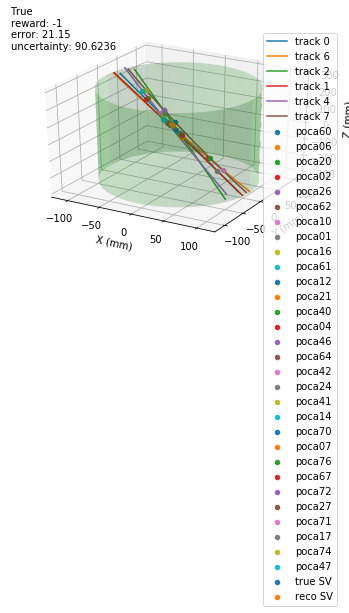

Closed figure
Episode ended naturally
Currently at event: 1
Steps done: 39
Reward for action 1: -1
[0, 1]
Did target update
Steps done: 41
Reward for action 2: -1
[0, 1, 2]
Steps done: 43
Reward for action 14: -1
[0, 1, 2]
Steps done: 45
Reward for action 1: -1
[0, 1, 2]
Steps done: 47
Reward for action 5: -1
[0, 1, 2, 5]
Steps done: 49
Reward for action 0: -1
[0, 1, 2, 5]
Steps done: 51
Reward for action 9: -1
[0, 2, 5]
Steps done: 53
Reward for action 11: -1
[0, 2, 5]
Steps done: 55
Reward for action 9: -1
[0, 2, 5]
Steps done: 57
Reward for action 3: -1
[0, 2, 5, 3]
Steps done: 59
Reward for action 10: -1
[0, 5, 3]
Did target update
Steps done: 61
Reward for action 13: -1
[0, 3]
Steps done: 63
Reward for action 14: -1
[0, 3]
Steps done: 65
Reward for action 3: -1
[0, 3]
Steps done: 67
Reward for action 5: -1
[0, 3, 5]
Steps done: 69
Reward for action 0: -1
[0, 3, 5]
Steps done: 71
Reward for action 6: -1
[0, 3, 5, 6]
Steps done: 73
Reward for action 5: -1
[0, 3, 5, 6]
Steps done: 75

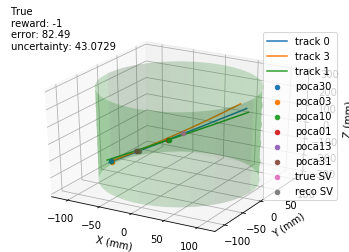

Closed figure
Episode ended naturally
Currently at event: 2
Steps done: 83
Reward for action 1: -1
[0, 1]
Steps done: 85
Reward for action 10: -1
[0, 1]
Steps done: 87
Reward for action 9: -1
[0]
Steps done: 89
Reward for action 1: -1
[0, 1]
Steps done: 91
Reward for action 11: -1
[0, 1]
Steps done: 93
Reward for action 12: -1
[0, 1]
Steps done: 95
Reward for action 1: -1
[0, 1]
Steps done: 97
Reward for action 11: -1
[0, 1]
Steps done: 99
Reward for action 9: -1
[0]
Did target update
Steps done: 101
Reward for action 3: -1
[0, 3]
Steps done: 103
Reward for action 13: -1
[0, 3]
Steps done: 105
Reward for action 16: -1
[0, 3]
Done flag
Trying to plot


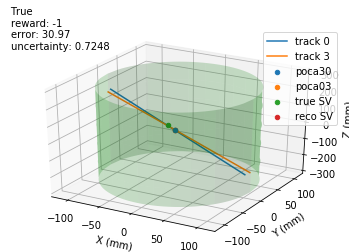

Closed figure
Episode ended naturally
Currently at event: 3
Steps done: 107
Reward for action 6: -1
[0]
Steps done: 109
Reward for action 13: -1
[0]
Steps done: 111
Reward for action 6: -1
[0]
Steps done: 113
Reward for action 9: -1
[0]
Steps done: 115
Reward for action 8: -1
[]
Steps done: 117
Reward for action 14: -1
[]
Steps done: 119
Reward for action 13: -1
[]
Did target update
Steps done: 121
Reward for action 15: -1
[]
Steps done: 123
Reward for action 3: -1
[3]
Steps done: 125
Reward for action 8: -1
[3]
Steps done: 127
Reward for action 10: -1
[3]
Steps done: 129
Reward for action 11: -1
[]
Steps done: 131
Reward for action 14: -1
[]
Steps done: 133
Reward for action 3: -1
[3]
Steps done: 135
Reward for action 4: 1
[3, 4]
Steps done: 137
Reward for action 10: -1
[3, 4]
Steps done: 139
Reward for action 4: -1
[3, 4]
Did target update
Steps done: 141
Reward for action 13: -1
[3, 4]
Steps done: 143
Reward for action 9: -1
[3, 4]
Steps done: 145
Reward for action 6: -1
[3, 4]
Step

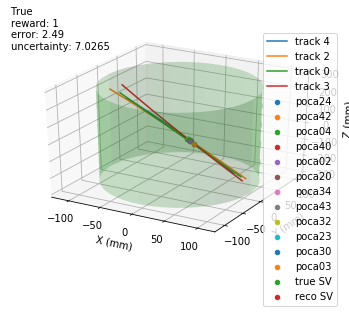

Closed figure
Episode ended naturally
Currently at event: 4
Steps done: 179
Reward for action 10: -1
[0]
Did target update
Steps done: 181
Reward for action 9: -1
[0]
Steps done: 183
Reward for action 6: -1
[0, 6]
Steps done: 185
Reward for action 11: -1
[0, 6]
Steps done: 187
Reward for action 13: -1
[0, 6]
Steps done: 189
Reward for action 14: -1
[0]
Steps done: 191
Reward for action 11: -1
[0]
Steps done: 193
Reward for action 5: -1
[0, 5]
Steps done: 195
Reward for action 5: -1
[0, 5]
Steps done: 197
Reward for action 14: -1
[0, 5]
Steps done: 199
Reward for action 15: -1
[0, 5]
Did target update
Steps done: 201
Reward for action 0: -1
[0, 5]
Steps done: 203
Reward for action 0: -1
[0, 5]
Steps done: 205
Reward for action 16: -1
[0, 5]
Done flag
Trying to plot


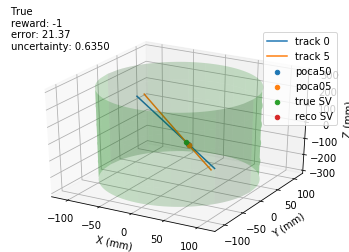

Closed figure
Episode ended naturally
Currently at event: 5
Steps done: 207
Reward for action 16: -1
[0]
Done flag
Trying to plot


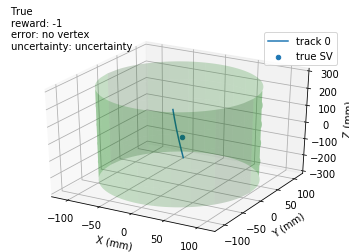

Closed figure
Episode ended naturally
Currently at event: 6
Steps done: 209
Reward for action 12: -1
[0]
Steps done: 211
Reward for action 14: -1
[0]
Steps done: 213
Reward for action 10: -1
[0]
Steps done: 215
Reward for action 3: 1
[0, 3]
Steps done: 217
Reward for action 2: 1
[0, 3, 2]
Steps done: 219
Reward for action 6: 1
[0, 3, 2, 6]
Did target update
Steps done: 221
Reward for action 2: -1
[0, 3, 2, 6]
Steps done: 223
Reward for action 2: -1
[0, 3, 2, 6]
Steps done: 225
Reward for action 15: -1
[0, 3, 2, 6]
Steps done: 227
Reward for action 4: 1
[0, 3, 2, 6, 4]
Steps done: 229
Reward for action 3: -1
[0, 3, 2, 6, 4]
Steps done: 231
Reward for action 10: 1
[0, 3, 6, 4]
Steps done: 233
Reward for action 5: 1
[0, 3, 6, 4, 5]
Steps done: 235
Reward for action 6: -1
[0, 3, 6, 4, 5]
Steps done: 237
Reward for action 10: -1
[0, 3, 6, 4, 5]
Steps done: 239
Reward for action 3: -1
[0, 3, 6, 4, 5]
Did target update
Steps done: 241
Reward for action 11: 1
[0, 6, 4, 5]
Steps done: 243
Rewar

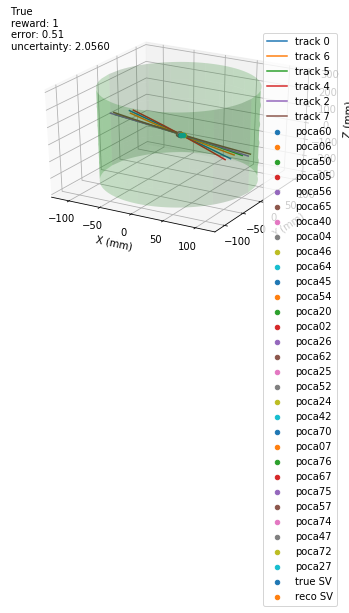

Closed figure
Episode ended naturally
Currently at event: 7
Steps done: 267
Reward for action 7: 1
[0, 7]
Steps done: 269
Reward for action 2: 1
[0, 7, 2]
Steps done: 271
Reward for action 14: -1
[0, 7, 2]
Steps done: 273
Reward for action 8: 1
[7, 2]
Steps done: 275
Reward for action 11: -1
[7, 2]
Steps done: 277
Reward for action 4: 1
[7, 2, 4]
Steps done: 279
Reward for action 13: -1
[7, 2, 4]
Did target update
Steps done: 281
Reward for action 1: 1
[7, 2, 4, 1]
Steps done: 283
Reward for action 8: -1
[7, 2, 4, 1]
Steps done: 285
Reward for action 7: -1
[7, 2, 4, 1]
Steps done: 287
Reward for action 12: 1
[7, 2, 1]
Steps done: 289
Reward for action 5: 1
[7, 2, 1, 5]
Steps done: 291
Reward for action 6: 1
[7, 2, 1, 5, 6]
Steps done: 293
Reward for action 12: -1
[7, 2, 1, 5, 6]
Steps done: 295
Reward for action 6: -1
[7, 2, 1, 5, 6]
Steps done: 297
Reward for action 14: 1
[7, 2, 1, 5]
Steps done: 299
Reward for action 9: 1
[7, 2, 5]
Did target update
Steps done: 301
Reward for action 

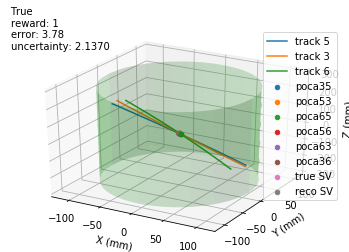

Closed figure
Episode ended naturally
Currently at event: 8
Steps done: 399
Reward for action 2: 1
[0, 2]
Did target update
Steps done: 401
Reward for action 4: 1
[0, 2, 4]
Steps done: 403
Reward for action 6: 1
[0, 2, 4, 6]
Steps done: 405
Reward for action 0: -1
[0, 2, 4, 6]
Steps done: 407
Reward for action 2: -1
[0, 2, 4, 6]
Steps done: 409
Reward for action 7: 1
[0, 2, 4, 6, 7]
Steps done: 411
Reward for action 16: 1
[0, 2, 4, 6, 7]
Done flag
Trying to plot


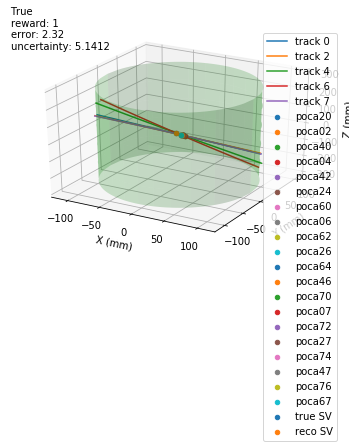

Closed figure
Episode ended naturally
Currently at event: 9
Steps done: 413
Reward for action 16: -1
[0]
Done flag
Trying to plot


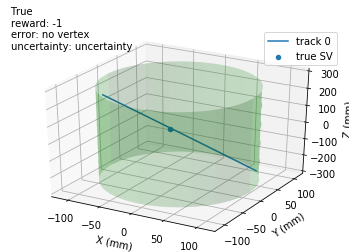

Closed figure
Episode ended naturally
Currently at event: 10
Steps done: 415
Reward for action 10: -1
[0]
Steps done: 417
Reward for action 3: 1
[0, 3]
Steps done: 419
Reward for action 4: 1
[0, 3, 4]
Did target update
Steps done: 421
Reward for action 11: 1
[0, 4]
Steps done: 423
Reward for action 3: 1
[0, 4, 3]
Steps done: 425
Reward for action 5: 1
[0, 4, 3, 5]
Steps done: 427
Reward for action 14: -1
[0, 4, 3, 5]
Steps done: 429
Reward for action 14: -1
[0, 4, 3, 5]
Steps done: 431
Reward for action 2: 1
[0, 4, 3, 5, 2]
Steps done: 433
Reward for action 10: 1
[0, 4, 3, 5]
Steps done: 435
Reward for action 9: -1
[0, 4, 3, 5]
Steps done: 437
Reward for action 5: -1
[0, 4, 3, 5]
Steps done: 439
Reward for action 10: -1
[0, 4, 3, 5]
Did target update
Steps done: 441
Reward for action 11: 1
[0, 4, 5]
Steps done: 443
Reward for action 16: 1
[0, 4, 5]
Done flag
Episode ended naturally
Currently at event: 11
Steps done: 445
Reward for action 4: -1
[0]
Steps done: 447
Reward for action 14: 

Reward for action 2: 1
[4, 6, 2]
Steps done: 727
Reward for action 1: 1
[4, 6, 2, 1]
Steps done: 729
Reward for action 7: -1
[4, 6, 2, 1]
Steps done: 731
Reward for action 11: -1
[4, 6, 2, 1]
Steps done: 733
Reward for action 0: 1
[4, 6, 2, 1, 0]
Steps done: 735
Reward for action 16: 1
[4, 6, 2, 1, 0]
Done flag
Episode ended naturally
Currently at event: 21
Steps done: 737
Reward for action 14: -1
[0]
Steps done: 739
Reward for action 0: -1
[0]
Did target update
Steps done: 741
Reward for action 3: 1
[0, 3]
Steps done: 743
Reward for action 2: 1
[0, 3, 2]
Steps done: 745
Reward for action 6: 1
[0, 3, 2, 6]
Steps done: 747
Reward for action 7: -1
[0, 3, 2, 6]
Steps done: 749
Reward for action 8: 1
[3, 2, 6]
Steps done: 751
Reward for action 9: -1
[3, 2, 6]
Steps done: 753
Reward for action 5: 1
[3, 2, 6, 5]
Steps done: 755
Reward for action 6: -1
[3, 2, 6, 5]
Steps done: 757
Reward for action 10: 1
[3, 6, 5]
Steps done: 759
Reward for action 2: 1
[3, 6, 5, 2]
Did target update
Steps don

Reward for action 2: 1
[5, 0, 3, 1, 4, 2]
Steps done: 1039
Reward for action 8: 1
[5, 3, 1, 4, 2]
Did target update
Steps done: 1041
Reward for action 7: -1
[5, 3, 1, 4, 2]
Steps done: 1043
Reward for action 9: 1
[5, 3, 4, 2]
Steps done: 1045
Reward for action 3: -1
[5, 3, 4, 2]
Steps done: 1047
Reward for action 2: -1
[5, 3, 4, 2]
Steps done: 1049
Reward for action 14: -1
[5, 3, 4, 2]
Steps done: 1051
Reward for action 16: 1
[5, 3, 4, 2]
Done flag
Episode ended naturally
Currently at event: 27
Steps done: 1053
Reward for action 6: -1
[0]
Steps done: 1055
Reward for action 6: -1
[0]
Steps done: 1057
Reward for action 11: -1
[0]
Steps done: 1059
Reward for action 3: 1
[0, 3]
Did target update
Steps done: 1061
Reward for action 3: -1
[0, 3]
Steps done: 1063
Reward for action 13: -1
[0, 3]
Steps done: 1065
Reward for action 13: -1
[0, 3]
Steps done: 1067
Reward for action 7: -1
[0, 3]
Steps done: 1069
Reward for action 15: -1
[0, 3]
Steps done: 1071
Reward for action 2: 1
[0, 3, 2]
Steps 

Steps done: 1367
Reward for action 7: -1
[0]
Steps done: 1369
Reward for action 8: -1
[]
Steps done: 1371
Reward for action 1: -1
[1]
Steps done: 1373
Reward for action 7: -1
[1]
Steps done: 1375
Reward for action 5: -1
[1]
Steps done: 1377
Reward for action 14: -1
[1]
Steps done: 1379
Reward for action 14: -1
[1]
Did target update
Steps done: 1381
Reward for action 10: -1
[1]
Steps done: 1383
Reward for action 11: -1
[1]
Steps done: 1385
Reward for action 0: 1
[1, 0]
Steps done: 1387
Reward for action 12: -1
[1, 0]
Steps done: 1389
Reward for action 11: -1
[1, 0]
Steps done: 1391
Reward for action 9: -1
[0]
Steps done: 1393
Reward for action 6: -1
[0]
Steps done: 1395
Reward for action 9: -1
[0]
Steps done: 1397
Reward for action 8: -1
[]
Steps done: 1399
Reward for action 8: -1
[]
Did target update
Steps done: 1401
Reward for action 15: -1
[]
Steps done: 1403
Reward for action 11: -1
[]
Steps done: 1405
Reward for action 13: -1
[]
Steps done: 1407
Reward for action 7: -1
[]
Steps don

Steps done: 1677
Reward for action 14: 1
[7, 5, 4, 2, 3]
Steps done: 1679
Reward for action 0: 1
[7, 5, 4, 2, 3, 0]
Did target update
Steps done: 1681
Reward for action 5: -1
[7, 5, 4, 2, 3, 0]
Steps done: 1683
Reward for action 10: 1
[7, 5, 4, 3, 0]
Steps done: 1685
Reward for action 12: 1
[7, 5, 3, 0]
Steps done: 1687
Reward for action 3: -1
[7, 5, 3, 0]
Steps done: 1689
Reward for action 1: 1
[7, 5, 3, 0, 1]
Steps done: 1691
Reward for action 2: 1
[7, 5, 3, 0, 1, 2]
Steps done: 1693
Reward for action 11: 1
[7, 5, 0, 1, 2]
Steps done: 1695
Reward for action 12: -1
[7, 5, 0, 1, 2]
Steps done: 1697
Reward for action 16: 1
[7, 5, 0, 1, 2]
Done flag
Episode ended naturally
Currently at event: 44
Steps done: 1699
Reward for action 11: -1
[0]
Did target update
Steps done: 1701
Reward for action 14: -1
[0]
Steps done: 1703
Reward for action 10: -1
[0]
Steps done: 1705
Reward for action 3: 1
[0, 3]
Steps done: 1707
Reward for action 11: -1
[0]
Steps done: 1709
Reward for action 7: 1
[0, 7]
S

Steps done: 1967
Reward for action 12: -1
[7]
Steps done: 1969
Reward for action 16: -1
[7]
Done flag
Episode ended naturally
Currently at event: 50
Steps done: 1971
Reward for action 13: -1
[0]
Steps done: 1973
Reward for action 8: -1
[]
Steps done: 1975
Reward for action 9: -1
[]
Steps done: 1977
Reward for action 12: -1
[]
Steps done: 1979
Reward for action 5: -1
[5]
Did target update
Steps done: 1981
Reward for action 5: -1
[5]
Steps done: 1983
Reward for action 5: -1
[5]
Steps done: 1985
Reward for action 8: -1
[5]
Steps done: 1987
Reward for action 4: 1
[5, 4]
Steps done: 1989
Reward for action 10: -1
[5, 4]
Steps done: 1991
Reward for action 13: -1
[4]
Steps done: 1993
Reward for action 7: 1
[4, 7]
Steps done: 1995
Reward for action 12: -1
[7]
Steps done: 1997
Reward for action 4: 1
[7, 4]
Steps done: 1999
Reward for action 12: -1
[7]
Did target update
Steps done: 2001
Reward for action 14: -1
[7]
Steps done: 2003
Reward for action 10: -1
[7]
Steps done: 2005
Reward for action 1

Steps done: 2277
Reward for action 9: -1
[4, 3, 7]
Steps done: 2279
Reward for action 6: 1
[4, 3, 7, 6]
Did target update
Steps done: 2281
Reward for action 14: 1
[4, 3, 7]
Steps done: 2283
Reward for action 5: 1
[4, 3, 7, 5]
Steps done: 2285
Reward for action 16: 1
[4, 3, 7, 5]
Done flag
Episode ended naturally
Currently at event: 61
Steps done: 2287
Reward for action 1: 1
[0, 1]
Steps done: 2289
Reward for action 10: -1
[0, 1]
Steps done: 2291
Reward for action 15: -1
[0, 1]
Steps done: 2293
Reward for action 14: -1
[0, 1]
Steps done: 2295
Reward for action 13: -1
[0, 1]
Steps done: 2297
Reward for action 14: -1
[0, 1]
Steps done: 2299
Reward for action 16: 1
[0, 1]
Did target update
Done flag
Episode ended naturally
Currently at event: 62
Steps done: 2301
Reward for action 5: -1
[0]
Steps done: 2303
Reward for action 5: -1
[0]
Steps done: 2305
Reward for action 13: -1
[0]
Steps done: 2307
Reward for action 2: 1
[0, 2]
Steps done: 2309
Reward for action 8: -1
[2]
Steps done: 2311
Rew

Reward for action 3: -1
[2, 4, 3]
Steps done: 2595
Reward for action 12: 1
[2, 3]
Steps done: 2597
Reward for action 10: -1
[3]
Steps done: 2599
Reward for action 3: -1
[3]
Did target update
Steps done: 2601
Reward for action 16: -1
[3]
Done flag
Episode ended naturally
Currently at event: 67
Steps done: 2603
Reward for action 16: -1
[0]
Done flag
Episode ended naturally
Currently at event: 68
Steps done: 2605
Reward for action 12: -1
[0]
Steps done: 2607
Reward for action 7: 1
[0, 7]
Steps done: 2609
Reward for action 12: -1
[0, 7]
Steps done: 2611
Reward for action 8: -1
[7]
Steps done: 2613
Reward for action 3: -1
[7, 3]
Steps done: 2615
Reward for action 5: 1
[7, 3, 5]
Steps done: 2617
Reward for action 5: -1
[7, 3, 5]
Steps done: 2619
Reward for action 6: -1
[7, 3, 5, 6]
Did target update
Steps done: 2621
Reward for action 6: -1
[7, 3, 5, 6]
Steps done: 2623
Reward for action 1: 1
[7, 3, 5, 6, 1]
Steps done: 2625
Reward for action 7: -1
[7, 3, 5, 6, 1]
Steps done: 2627
Reward for 

Steps done: 2883
Reward for action 10: -1
[0, 5]
Steps done: 2885
Reward for action 5: -1
[0, 5]
Steps done: 2887
Reward for action 9: -1
[0, 5]
Steps done: 2889
Reward for action 6: 1
[0, 5, 6]
Steps done: 2891
Reward for action 9: -1
[0, 5, 6]
Steps done: 2893
Reward for action 8: 1
[5, 6]
Steps done: 2895
Reward for action 13: -1
[6]
Steps done: 2897
Reward for action 4: 1
[6, 4]
Steps done: 2899
Reward for action 13: -1
[6, 4]
Did target update
Steps done: 2901
Reward for action 12: -1
[6]
Steps done: 2903
Reward for action 0: 1
[6, 0]
Steps done: 2905
Reward for action 2: 1
[6, 0, 2]
Steps done: 2907
Reward for action 8: 1
[6, 2]
Steps done: 2909
Reward for action 16: 1
[6, 2]
Done flag
Episode ended naturally
Currently at event: 79
Steps done: 2911
Reward for action 14: -1
[0]
Steps done: 2913
Reward for action 10: -1
[0]
Steps done: 2915
Reward for action 8: -1
[]
Steps done: 2917
Reward for action 2: -1
[2]
Steps done: 2919
Reward for action 12: -1
[2]
Did target update
Steps d

Reward for action 1: -1
[6, 2, 4, 3, 5, 1]
Steps done: 3185
Reward for action 16: 1
[6, 2, 4, 3, 5, 1]
Done flag
Episode ended naturally
Currently at event: 89
Steps done: 3187
Reward for action 14: -1
[0]
Steps done: 3189
Reward for action 7: -1
[0]
Steps done: 3191
Reward for action 12: -1
[0]
Steps done: 3193
Reward for action 6: -1
[0]
Steps done: 3195
Reward for action 0: -1
[0]
Steps done: 3197
Reward for action 13: -1
[0]
Steps done: 3199
Reward for action 3: 1
[0, 3]
Did target update
Steps done: 3201
Reward for action 1: 1
[0, 3, 1]
Steps done: 3203
Reward for action 5: 1
[0, 3, 1, 5]
Steps done: 3205
Reward for action 12: -1
[0, 3, 1, 5]
Steps done: 3207
Reward for action 6: -1
[0, 3, 1, 5]
Steps done: 3209
Reward for action 6: -1
[0, 3, 1, 5]
Steps done: 3211
Reward for action 16: 1
[0, 3, 1, 5]
Done flag
Episode ended naturally
Currently at event: 90
Steps done: 3213
Reward for action 15: -1
[0]
Steps done: 3215
Reward for action 12: -1
[0]
Steps done: 3217
Reward for actio

Reward for action 0: 1
[1, 2, 0]
Steps done: 3489
Reward for action 11: -1
[1, 2, 0]
Steps done: 3491
Reward for action 9: 1
[2, 0]
Steps done: 3493
Reward for action 10: -1
[0]
Steps done: 3495
Reward for action 1: 1
[0, 1]
Steps done: 3497
Reward for action 7: -1
[0, 1]
Steps done: 3499
Reward for action 15: -1
[0, 1]
Did target update
Steps done: 3501
Reward for action 6: -1
[0, 1]
Steps done: 3503
Reward for action 0: -1
[0, 1]
Steps done: 3505
Reward for action 12: -1
[0, 1]
Steps done: 3507
Reward for action 13: -1
[0, 1]
Steps done: 3509
Reward for action 12: -1
[0, 1]
Steps done: 3511
Reward for action 5: 1
[0, 1, 5]
Steps done: 3513
Reward for action 7: -1
[0, 1, 5]
Steps done: 3515
Reward for action 1: -1
[0, 1, 5]
Steps done: 3517
Reward for action 3: 1
[0, 1, 5, 3]
Steps done: 3519
Reward for action 0: -1
[0, 1, 5, 3]
Did target update
Steps done: 3521
Reward for action 11: 1
[0, 1, 5]
Steps done: 3523
Reward for action 13: 1
[0, 1]
Steps done: 3525
Reward for action 2: 1
[

Reward for action 1: -1
[0, 2, 1]
Steps done: 3809
Reward for action 8: -1
[2, 1]
Steps done: 3811
Reward for action 12: -1
[2, 1]
Steps done: 3813
Reward for action 8: -1
[2, 1]
Steps done: 3815
Reward for action 12: -1
[2, 1]
Steps done: 3817
Reward for action 16: -1
[2, 1]
Done flag
Episode ended naturally
Currently at event: 108
Steps done: 3819
Reward for action 15: -1
[0]
Did target update
Steps done: 3821
Reward for action 6: 1
[0, 6]
Steps done: 3823
Reward for action 12: -1
[0, 6]
Steps done: 3825
Reward for action 16: 1
[0, 6]
Done flag
Episode ended naturally
Currently at event: 109
Steps done: 3827
Reward for action 16: -1
[0]
Done flag
Episode ended naturally
Currently at event: 110
Steps done: 3829
Reward for action 9: -1
[0]
Steps done: 3831
Reward for action 12: -1
[0]
Steps done: 3833
Reward for action 10: -1
[0]
Steps done: 3835
Reward for action 6: -1
[0, 6]
Steps done: 3837
Reward for action 5: 1
[0, 6, 5]
Steps done: 3839
Reward for action 4: 1
[0, 6, 5, 4]
Did tar

Steps done: 4133
Reward for action 2: 1
[1, 6, 5, 3, 2]
Steps done: 4135
Reward for action 16: 1
[1, 6, 5, 3, 2]
Done flag
Episode ended naturally
Currently at event: 116
Steps done: 4137
Reward for action 5: -1
[0]
Steps done: 4139
Reward for action 8: -1
[]
Did target update
Steps done: 4141
Reward for action 8: -1
[]
Steps done: 4143
Reward for action 7: -1
[]
Steps done: 4145
Reward for action 10: -1
[]
Steps done: 4147
Reward for action 8: -1
[]
Steps done: 4149
Reward for action 16: -1
[]
Done flag
Episode ended naturally
Currently at event: 117
Steps done: 4151
Reward for action 16: -1
[0]
Done flag
Episode ended naturally
Currently at event: 118
Steps done: 4153
Reward for action 8: -1
[]
Steps done: 4155
Reward for action 8: -1
[]
Steps done: 4157
Reward for action 8: -1
[]
Steps done: 4159
Reward for action 10: -1
[]
Did target update
Steps done: 4161
Reward for action 3: -1
[3]
Steps done: 4163
Reward for action 9: -1
[3]
Steps done: 4165
Reward for action 11: -1
[]
Steps do

Steps done: 4445
Reward for action 9: -1
[]
Steps done: 4447
Reward for action 3: -1
[3]
Steps done: 4449
Reward for action 0: -1
[3, 0]
Steps done: 4451
Reward for action 8: -1
[3]
Steps done: 4453
Reward for action 8: -1
[3]
Steps done: 4455
Reward for action 10: -1
[3]
Steps done: 4457
Reward for action 8: -1
[3]
Steps done: 4459
Reward for action 8: -1
[3]
Did target update
Steps done: 4461
Reward for action 8: -1
[3]
Steps done: 4463
Reward for action 4: 1
[3, 4]
Steps done: 4465
Reward for action 15: -1
[3, 4]
Steps done: 4467
Reward for action 13: -1
[3, 4]
Steps done: 4469
Reward for action 7: -1
[3, 4]
Steps done: 4471
Reward for action 8: -1
[3, 4]
Steps done: 4473
Reward for action 3: -1
[3, 4]
Steps done: 4475
Reward for action 16: 1
[3, 4]
Done flag
Episode ended naturally
Currently at event: 125
Steps done: 4477
Reward for action 3: -1
[0, 3]
Steps done: 4479
Reward for action 14: -1
[0, 3]
Did target update
Steps done: 4481
Reward for action 8: -1
[3]
Steps done: 4483
Re

Steps done: 4797
Reward for action 10: -1
[]
Steps done: 4799
Reward for action 9: -1
[]
Did target update
Steps done: 4801
Reward for action 9: -1
[]
Steps done: 4803
Reward for action 12: -1
[]
Steps done: 4805
Reward for action 7: -1
[]
Steps done: 4807
Reward for action 4: -1
[4]
Steps done: 4809
Reward for action 6: -1
[4]
Steps done: 4811
Reward for action 8: -1
[4]
Steps done: 4813
Reward for action 5: 1
[4, 5]
Steps done: 4815
Reward for action 8: -1
[4, 5]
Steps done: 4817
Reward for action 7: -1
[4, 5]
Steps done: 4819
Reward for action 8: -1
[4, 5]
Did target update
Steps done: 4821
Reward for action 8: -1
[4, 5]
Steps done: 4823
Reward for action 0: 1
[4, 5, 0]
Steps done: 4825
Reward for action 8: 1
[4, 5]
Steps done: 4827
Reward for action 15: -1
[4, 5]
Steps done: 4829
Reward for action 3: 1
[4, 5, 3]
Steps done: 4831
Reward for action 12: 1
[5, 3]
Steps done: 4833
Reward for action 15: -1
[5, 3]
Steps done: 4835
Reward for action 7: -1
[5, 3]
Steps done: 4837
Reward for

Steps done: 5119
Reward for action 10: 1
[4, 5]
Did target update
Steps done: 5121
Reward for action 10: -1
[4, 5]
Steps done: 5123
Reward for action 11: -1
[4, 5]
Steps done: 5125
Reward for action 15: -1
[4, 5]
Steps done: 5127
Reward for action 0: 1
[4, 5, 0]
Steps done: 5129
Reward for action 6: 1
[4, 5, 0, 6]
Steps done: 5131
Reward for action 6: -1
[4, 5, 0, 6]
Steps done: 5133
Reward for action 15: -1
[4, 5, 0, 6]
Steps done: 5135
Reward for action 13: 1
[4, 0, 6]
Steps done: 5137
Reward for action 10: -1
[4, 0, 6]
Steps done: 5139
Reward for action 8: 1
[4, 6]
Did target update
Steps done: 5141
Reward for action 6: -1
[4, 6]
Steps done: 5143
Reward for action 16: 1
[4, 6]
Done flag
Episode ended naturally
Currently at event: 135
Steps done: 5145
Reward for action 16: -1
[0]
Done flag
Episode ended naturally
Currently at event: 136
Steps done: 5147
Reward for action 11: -1
[0]
Steps done: 5149
Reward for action 10: -1
[0]
Steps done: 5151
Reward for action 9: -1
[0]
Steps done: 

Reward for action 5: 1
[2, 1, 4, 5]
Steps done: 5433
Reward for action 16: 1
[2, 1, 4, 5]
Done flag
Episode ended naturally
Currently at event: 146
Steps done: 5435
Reward for action 9: -1
[0]
Steps done: 5437
Reward for action 1: 1
[0, 1]
Steps done: 5439
Reward for action 12: -1
[0, 1]
Did target update
Steps done: 5441
Reward for action 5: 1
[0, 1, 5]
Steps done: 5443
Reward for action 13: 1
[0, 1]
Steps done: 5445
Reward for action 9: -1
[0]
Steps done: 5447
Reward for action 2: 1
[0, 2]
Steps done: 5449
Reward for action 2: -1
[0, 2]
Steps done: 5451
Reward for action 11: -1
[0, 2]
Steps done: 5453
Reward for action 12: -1
[0, 2]
Steps done: 5455
Reward for action 4: 1
[0, 2, 4]
Steps done: 5457
Reward for action 12: 1
[0, 2]
Steps done: 5459
Reward for action 8: -1
[2]
Did target update
Steps done: 5461
Reward for action 12: -1
[2]
Steps done: 5463
Reward for action 15: -1
[2]
Steps done: 5465
Reward for action 11: -1
[2]
Steps done: 5467
Reward for action 7: -1
[2]
Steps done: 5

Steps done: 5755
Reward for action 8: -1
[1]
Steps done: 5757
Reward for action 12: -1
[1]
Steps done: 5759
Reward for action 8: -1
[1]
Did target update
Steps done: 5761
Reward for action 11: -1
[1]
Steps done: 5763
Reward for action 6: 1
[1, 6]
Steps done: 5765
Reward for action 12: -1
[1, 6]
Steps done: 5767
Reward for action 13: -1
[1, 6]
Steps done: 5769
Reward for action 9: -1
[6]
Steps done: 5771
Reward for action 12: -1
[6]
Steps done: 5773
Reward for action 13: -1
[6]
Steps done: 5775
Reward for action 11: -1
[6]
Steps done: 5777
Reward for action 7: 1
[6, 7]
Steps done: 5779
Reward for action 7: -1
[6, 7]
Did target update
Steps done: 5781
Reward for action 11: -1
[6, 7]
Steps done: 5783
Reward for action 13: -1
[6, 7]
Steps done: 5785
Reward for action 16: 1
[6, 7]
Done flag
Episode ended naturally
Currently at event: 158
Steps done: 5787
Reward for action 12: -1
[0]
Steps done: 5789
Reward for action 1: -1
[0, 1]
Steps done: 5791
Reward for action 2: -1
[0, 1, 2]
Steps done

Reward for action 1: -1
[0, 1]
Steps done: 6067
Reward for action 9: -1
[0]
Steps done: 6069
Reward for action 1: -1
[0, 1]
Steps done: 6071
Reward for action 13: -1
[0, 1]
Steps done: 6073
Reward for action 5: -1
[0, 1]
Steps done: 6075
Reward for action 11: -1
[0, 1]
Steps done: 6077
Reward for action 7: -1
[0, 1]
Steps done: 6079
Reward for action 13: -1
[0, 1]
Did target update
Steps done: 6081
Reward for action 1: -1
[0, 1]
Steps done: 6083
Reward for action 10: -1
[0, 1]
Steps done: 6085
Reward for action 1: -1
[0, 1]
Steps done: 6087
Reward for action 8: -1
[1]
Steps done: 6089
Reward for action 3: -1
[1]
Steps done: 6091
Reward for action 14: -1
[1]
Steps done: 6093
Reward for action 1: -1
[1]
Steps done: 6095
Reward for action 13: -1
[1]
Steps done: 6097
Reward for action 10: -1
[1]
Steps done: 6099
Reward for action 16: -1
[1]
Did target update
Done flag
Episode ended naturally
Currently at event: 168
Steps done: 6101
Reward for action 10: -1
[0]
Steps done: 6103
Reward for a

Reward for action 2: 1
[0, 4, 2]
Steps done: 6399
Reward for action 13: -1
[0, 4, 2]
Did target update
Steps done: 6401
Reward for action 8: 1
[4, 2]
Steps done: 6403
Reward for action 15: -1
[4, 2]
Steps done: 6405
Reward for action 3: 1
[4, 2, 3]
Steps done: 6407
Reward for action 11: 1
[4, 2]
Steps done: 6409
Reward for action 8: -1
[4, 2]
Steps done: 6411
Reward for action 8: -1
[4, 2]
Steps done: 6413
Reward for action 14: -1
[4, 2]
Steps done: 6415
Reward for action 8: -1
[4, 2]
Steps done: 6417
Reward for action 8: -1
[4, 2]
Steps done: 6419
Reward for action 8: -1
[4, 2]
Did target update
Steps done: 6421
Reward for action 8: -1
[4, 2]
Steps done: 6423
Reward for action 12: -1
[2]
Steps done: 6425
Reward for action 8: -1
[2]
Steps done: 6427
Reward for action 8: -1
[2]
Steps done: 6429
Reward for action 2: -1
[2]
Steps done: 6431
Reward for action 7: 1
[2, 7]
Steps done: 6433
Reward for action 8: -1
[2, 7]
Steps done: 6435
Reward for action 0: 1
[2, 7, 0]
Steps done: 6437
Rewar

Reward for action 1: -1
[2, 5, 6, 0, 3, 7, 1]
Steps done: 6703
Reward for action 13: -1
[2, 6, 0, 3, 7, 1]
Steps done: 6705
Reward for action 1: -1
[2, 6, 0, 3, 7, 1]
Steps done: 6707
Reward for action 16: -1
[2, 6, 0, 3, 7, 1]
Done flag
Episode ended naturally
Currently at event: 181
Steps done: 6709
Reward for action 8: -1
[]
Steps done: 6711
Reward for action 16: -1
[]
Done flag
Episode ended naturally
Currently at event: 182
Steps done: 6713
Reward for action 6: 1
[0, 6]
Steps done: 6715
Reward for action 2: 1
[0, 6, 2]
Steps done: 6717
Reward for action 15: -1
[0, 6, 2]
Steps done: 6719
Reward for action 2: -1
[0, 6, 2]
Did target update
Steps done: 6721
Reward for action 4: 1
[0, 6, 2, 4]
Steps done: 6723
Reward for action 1: 1
[0, 6, 2, 4, 1]
Steps done: 6725
Reward for action 8: 1
[6, 2, 4, 1]
Steps done: 6727
Reward for action 8: -1
[6, 2, 4, 1]
Steps done: 6729
Reward for action 3: 1
[6, 2, 4, 1, 3]
Steps done: 6731
Reward for action 8: -1
[6, 2, 4, 1, 3]
Steps done: 6733
Rew

Reward for action 5: 1
[7, 0, 6, 3, 1, 5]
Steps done: 7003
Reward for action 10: -1
[7, 0, 6, 3, 1, 5]
Steps done: 7005
Reward for action 9: 1
[7, 0, 6, 3, 5]
Steps done: 7007
Reward for action 13: 1
[7, 0, 6, 3]
Steps done: 7009
Reward for action 12: -1
[7, 0, 6, 3]
Steps done: 7011
Reward for action 3: -1
[7, 0, 6, 3]
Steps done: 7013
Reward for action 12: -1
[7, 0, 6, 3]
Steps done: 7015
Reward for action 12: -1
[7, 0, 6, 3]
Steps done: 7017
Reward for action 11: 1
[7, 0, 6]
Steps done: 7019
Reward for action 12: -1
[7, 0, 6]
Did target update
Steps done: 7021
Reward for action 12: -1
[7, 0, 6]
Steps done: 7023
Reward for action 12: -1
[7, 0, 6]
Steps done: 7025
Reward for action 12: -1
[7, 0, 6]
Steps done: 7027
Reward for action 5: 1
[7, 0, 6, 5]
Steps done: 7029
Reward for action 12: -1
[7, 0, 6, 5]
Steps done: 7031
Reward for action 0: -1
[7, 0, 6, 5]
Steps done: 7033
Reward for action 10: -1
[7, 0, 6, 5]
Steps done: 7035
Reward for action 1: 1
[7, 0, 6, 5, 1]
Steps done: 7037
R

Steps done: 7309
Reward for action 12: -1
[0, 5, 7]
Steps done: 7311
Reward for action 5: -1
[0, 5, 7]
Steps done: 7313
Reward for action 12: -1
[0, 5, 7]
Steps done: 7315
Reward for action 12: -1
[0, 5, 7]
Steps done: 7317
Reward for action 8: 1
[5, 7]
Steps done: 7319
Reward for action 4: 1
[5, 7, 4]
Did target update
Steps done: 7321
Reward for action 14: -1
[5, 7, 4]
Steps done: 7323
Reward for action 15: 1
[5, 4]
Steps done: 7325
Reward for action 13: -1
[4]
Steps done: 7327
Reward for action 1: 1
[4, 1]
Steps done: 7329
Reward for action 16: 1
[4, 1]
Done flag
Episode ended naturally
Currently at event: 187
Steps done: 7331
Reward for action 6: -1
[0, 6]
Steps done: 7333
Reward for action 3: 1
[0, 6, 3]
Steps done: 7335
Reward for action 9: -1
[0, 6, 3]
Steps done: 7337
Reward for action 14: 1
[0, 3]
Steps done: 7339
Reward for action 4: 1
[0, 3, 4]
Did target update
Steps done: 7341
Reward for action 13: -1
[0, 3, 4]
Steps done: 7343
Reward for action 7: 1
[0, 3, 4, 7]
Steps don

Reward for action 3: 1
[1, 2, 3]
Steps done: 7639
Reward for action 12: -1
[1, 2, 3]
Did target update
Steps done: 7641
Reward for action 12: -1
[1, 2, 3]
Steps done: 7643
Reward for action 13: -1
[1, 2, 3]
Steps done: 7645
Reward for action 12: -1
[1, 2, 3]
Steps done: 7647
Reward for action 16: 1
[1, 2, 3]
Done flag
Episode ended naturally
Currently at event: 191
Steps done: 7649
Reward for action 12: -1
[0]
Steps done: 7651
Reward for action 5: 1
[0, 5]
Steps done: 7653
Reward for action 9: -1
[0, 5]
Steps done: 7655
Reward for action 12: -1
[0, 5]
Steps done: 7657
Reward for action 3: 1
[0, 5, 3]
Steps done: 7659
Reward for action 15: -1
[0, 5, 3]
Did target update
Steps done: 7661
Reward for action 10: -1
[0, 5, 3]
Steps done: 7663
Reward for action 10: -1
[0, 5, 3]
Steps done: 7665
Reward for action 11: 1
[0, 5]
Steps done: 7667
Reward for action 12: -1
[0, 5]
Steps done: 7669
Reward for action 6: 1
[0, 5, 6]
Steps done: 7671
Reward for action 12: -1
[0, 5, 6]
Steps done: 7673
Re

Steps done: 7953
Reward for action 4: 1
[5, 2, 4]
Steps done: 7955
Reward for action 11: -1
[5, 2, 4]
Steps done: 7957
Reward for action 6: 1
[5, 2, 4, 6]
Steps done: 7959
Reward for action 14: 1
[5, 2, 4]
Did target update
Steps done: 7961
Reward for action 12: 1
[5, 2]
Steps done: 7963
Reward for action 12: -1
[5, 2]
Steps done: 7965
Reward for action 1: 1
[5, 2, 1]
Steps done: 7967
Reward for action 6: 1
[5, 2, 1, 6]
Steps done: 7969
Reward for action 5: -1
[5, 2, 1, 6]
Steps done: 7971
Reward for action 12: -1
[5, 2, 1, 6]
Steps done: 7973
Reward for action 4: 1
[5, 2, 1, 6, 4]
Steps done: 7975
Reward for action 12: 1
[5, 2, 1, 6]
Steps done: 7977
Reward for action 15: -1
[5, 2, 1, 6]
Steps done: 7979
Reward for action 15: -1
[5, 2, 1, 6]
Did target update
Steps done: 7981
Reward for action 5: -1
[5, 2, 1, 6]
Steps done: 7983
Reward for action 12: -1
[5, 2, 1, 6]
Steps done: 7985
Reward for action 12: -1
[5, 2, 1, 6]
Steps done: 7987
Reward for action 4: 1
[5, 2, 1, 6, 4]
Steps don

Reward for action 7: 1
[0, 7]
Steps done: 8255
Reward for action 3: 1
[0, 7, 3]
Steps done: 8257
Reward for action 12: -1
[0, 7, 3]
Steps done: 8259
Reward for action 12: -1
[0, 7, 3]
Did target update
Steps done: 8261
Reward for action 1: 1
[0, 7, 3, 1]
Steps done: 8263
Reward for action 12: -1
[0, 7, 3, 1]
Steps done: 8265
Reward for action 16: 1
[0, 7, 3, 1]
Done flag
Episode ended naturally
Currently at event: 208
Steps done: 8267
Reward for action 3: -1
[0, 3]
Steps done: 8269
Reward for action 5: 1
[0, 3, 5]
Steps done: 8271
Reward for action 9: -1
[0, 3, 5]
Steps done: 8273
Reward for action 12: -1
[0, 3, 5]
Steps done: 8275
Reward for action 12: -1
[0, 3, 5]
Steps done: 8277
Reward for action 0: -1
[0, 3, 5]
Steps done: 8279
Reward for action 8: -1
[3, 5]
Did target update
Steps done: 8281
Reward for action 12: -1
[3, 5]
Steps done: 8283
Reward for action 15: -1
[3, 5]
Steps done: 8285
Reward for action 12: -1
[3, 5]
Steps done: 8287
Reward for action 1: -1
[3, 5, 1]
Steps done

Reward for action 0: 1
[1, 6, 0]
Steps done: 8567
Reward for action 0: -1
[1, 6, 0]
Steps done: 8569
Reward for action 7: 1
[1, 6, 0, 7]
Steps done: 8571
Reward for action 7: -1
[1, 6, 0, 7]
Steps done: 8573
Reward for action 12: -1
[1, 6, 0, 7]
Steps done: 8575
Reward for action 12: -1
[1, 6, 0, 7]
Steps done: 8577
Reward for action 16: 1
[1, 6, 0, 7]
Done flag
Episode ended naturally
Currently at event: 212
Steps done: 8579
Reward for action 1: 1
[0, 1]
Did target update
Steps done: 8581
Reward for action 5: 1
[0, 1, 5]
Steps done: 8583
Reward for action 2: 1
[0, 1, 5, 2]
Steps done: 8585
Reward for action 16: 1
[0, 1, 5, 2]
Done flag
Episode ended naturally
Currently at event: 213
Steps done: 8587
Reward for action 15: -1
[0]
Steps done: 8589
Reward for action 12: -1
[0]
Steps done: 8591
Reward for action 9: -1
[0]
Steps done: 8593
Reward for action 9: -1
[0]
Steps done: 8595
Reward for action 12: -1
[0]
Steps done: 8597
Reward for action 15: -1
[0]
Steps done: 8599
Reward for actio

Steps done: 8903
Reward for action 8: -1
[]
Steps done: 8905
Reward for action 3: -1
[3]
Steps done: 8907
Reward for action 11: -1
[]
Steps done: 8909
Reward for action 4: -1
[]
Steps done: 8911
Reward for action 1: -1
[1]
Steps done: 8913
Reward for action 3: 1
[1, 3]
Steps done: 8915
Reward for action 5: -1
[1, 3]
Steps done: 8917
Reward for action 12: -1
[1, 3]
Steps done: 8919
Reward for action 10: -1
[1, 3]
Did target update
Steps done: 8921
Reward for action 0: 1
[1, 3, 0]
Steps done: 8923
Reward for action 12: -1
[1, 3, 0]
Steps done: 8925
Reward for action 11: 1
[1, 0]
Steps done: 8927
Reward for action 11: -1
[1, 0]
Steps done: 8929
Reward for action 12: -1
[1, 0]
Steps done: 8931
Reward for action 12: -1
[1, 0]
Steps done: 8933
Reward for action 7: -1
[1, 0]
Steps done: 8935
Reward for action 11: -1
[1, 0]
Steps done: 8937
Reward for action 1: -1
[1, 0]
Steps done: 8939
Reward for action 10: -1
[1, 0]
Did target update
Steps done: 8941
Reward for action 12: -1
[1, 0]
Steps do

Done flag
Episode ended naturally
Currently at event: 229
Steps done: 9239
Reward for action 12: -1
[0]
Did target update
Steps done: 9241
Reward for action 14: -1
[0]
Steps done: 9243
Reward for action 12: -1
[0]
Steps done: 9245
Reward for action 4: -1
[0, 4]
Steps done: 9247
Reward for action 8: -1
[4]
Steps done: 9249
Reward for action 5: 1
[4, 5]
Steps done: 9251
Reward for action 12: -1
[5]
Steps done: 9253
Reward for action 9: -1
[5]
Steps done: 9255
Reward for action 1: -1
[5, 1]
Steps done: 9257
Reward for action 15: -1
[5, 1]
Steps done: 9259
Reward for action 8: -1
[5, 1]
Did target update
Steps done: 9261
Reward for action 11: -1
[5, 1]
Steps done: 9263
Reward for action 12: -1
[5, 1]
Steps done: 9265
Reward for action 0: -1
[5, 1, 0]
Steps done: 9267
Reward for action 14: -1
[5, 1, 0]
Steps done: 9269
Reward for action 4: -1
[5, 1, 0, 4]
Steps done: 9271
Reward for action 16: -1
[5, 1, 0, 4]
Done flag
Episode ended naturally
Currently at event: 230
Steps done: 9273
Reward 

Reward for action 1: -1
[0, 3, 7, 6, 1]
Steps done: 9545
Reward for action 1: -1
[0, 3, 7, 6, 1]
Steps done: 9547
Reward for action 1: -1
[0, 3, 7, 6, 1]
Steps done: 9549
Reward for action 4: -1
[0, 3, 7, 6, 1, 4]
Steps done: 9551
Reward for action 1: -1
[0, 3, 7, 6, 1, 4]
Steps done: 9553
Reward for action 3: -1
[0, 3, 7, 6, 1, 4]
Steps done: 9555
Reward for action 15: -1
[0, 3, 6, 1, 4]
Steps done: 9557
Reward for action 15: -1
[0, 3, 6, 1, 4]
Steps done: 9559
Reward for action 15: -1
[0, 3, 6, 1, 4]
Did target update
Steps done: 9561
Reward for action 5: 1
[0, 3, 6, 1, 4, 5]
Steps done: 9563
Reward for action 1: -1
[0, 3, 6, 1, 4, 5]
Steps done: 9565
Reward for action 0: -1
[0, 3, 6, 1, 4, 5]
Steps done: 9567
Reward for action 4: -1
[0, 3, 6, 1, 4, 5]
Steps done: 9569
Reward for action 4: -1
[0, 3, 6, 1, 4, 5]
Steps done: 9571
Reward for action 1: -1
[0, 3, 6, 1, 4, 5]
Steps done: 9573
Reward for action 11: -1
[0, 6, 1, 4, 5]
Steps done: 9575
Reward for action 3: 1
[0, 6, 1, 4, 5, 3

Did target update
Steps done: 9841
Reward for action 2: 1
[1, 5, 2]
Steps done: 9843
Reward for action 11: -1
[1, 5, 2]
Steps done: 9845
Reward for action 4: 1
[1, 5, 2, 4]
Steps done: 9847
Reward for action 3: 1
[1, 5, 2, 4, 3]
Steps done: 9849
Reward for action 15: -1
[1, 5, 2, 4, 3]
Steps done: 9851
Reward for action 6: 1
[1, 5, 2, 4, 3, 6]
Steps done: 9853
Reward for action 15: -1
[1, 5, 2, 4, 3, 6]
Steps done: 9855
Reward for action 1: -1
[1, 5, 2, 4, 3, 6]
Steps done: 9857
Reward for action 11: 1
[1, 5, 2, 4, 6]
Steps done: 9859
Reward for action 8: -1
[1, 5, 2, 4, 6]
Did target update
Steps done: 9861
Reward for action 2: -1
[1, 5, 2, 4, 6]
Steps done: 9863
Reward for action 15: -1
[1, 5, 2, 4, 6]
Steps done: 9865
Reward for action 8: -1
[1, 5, 2, 4, 6]
Steps done: 9867
Reward for action 8: -1
[1, 5, 2, 4, 6]
Steps done: 9869
Reward for action 8: -1
[1, 5, 2, 4, 6]
Steps done: 9871
Reward for action 2: -1
[1, 5, 2, 4, 6]
Steps done: 9873
Reward for action 8: -1
[1, 5, 2, 4, 6]
S

Steps done: 10137
Reward for action 12: -1
[5]
Steps done: 10139
Reward for action 16: -1
[5]
Did target update
Done flag
Episode ended naturally
Currently at event: 248
Steps done: 10141
Reward for action 13: -1
[0]
Steps done: 10143
Reward for action 12: -1
[0]
Steps done: 10145
Reward for action 14: -1
[0]
Steps done: 10147
Reward for action 10: -1
[0]
Steps done: 10149
Reward for action 3: 1
[0, 3]
Steps done: 10151
Reward for action 4: 1
[0, 3, 4]
Steps done: 10153
Reward for action 11: 1
[0, 4]
Steps done: 10155
Reward for action 12: -1
[0]
Steps done: 10157
Reward for action 12: -1
[0]
Steps done: 10159
Reward for action 12: -1
[0]
Did target update
Steps done: 10161
Reward for action 0: -1
[0]
Steps done: 10163
Reward for action 12: -1
[0]
Steps done: 10165
Reward for action 12: -1
[0]
Steps done: 10167
Reward for action 3: 1
[0, 3]
Steps done: 10169
Reward for action 4: 1
[0, 3, 4]
Steps done: 10171
Reward for action 12: 1
[0, 3]
Steps done: 10173
Reward for action 4: 1
[0, 3,

Steps done: 10439
Reward for action 11: 1
[2, 1]
Did target update
Steps done: 10441
Reward for action 0: -1
[2, 1, 0]
Steps done: 10443
Reward for action 12: -1
[2, 1, 0]
Steps done: 10445
Reward for action 5: -1
[2, 1, 0, 5]
Steps done: 10447
Reward for action 6: -1
[2, 1, 0, 5]
Steps done: 10449
Reward for action 15: -1
[2, 1, 0, 5]
Steps done: 10451
Reward for action 5: -1
[2, 1, 0, 5]
Steps done: 10453
Reward for action 12: -1
[2, 1, 0, 5]
Steps done: 10455
Reward for action 13: -1
[2, 1, 0]
Steps done: 10457
Reward for action 13: -1
[2, 1, 0]
Steps done: 10459
Reward for action 10: -1
[1, 0]
Did target update
Steps done: 10461
Reward for action 8: -1
[1]
Steps done: 10463
Reward for action 14: -1
[1]
Steps done: 10465
Reward for action 1: -1
[1]
Steps done: 10467
Reward for action 12: -1
[1]
Steps done: 10469
Reward for action 12: -1
[1]
Steps done: 10471
Reward for action 3: -1
[1, 3]
Steps done: 10473
Reward for action 12: -1
[1, 3]
Steps done: 10475
Reward for action 7: -1
[1,

Reward for action 4: -1
[1, 0, 4]
Steps done: 10753
Reward for action 12: -1
[1, 0]
Steps done: 10755
Reward for action 16: -1
[1, 0]
Done flag
Episode ended naturally
Currently at event: 260
Steps done: 10757
Reward for action 2: -1
[0, 2]
Steps done: 10759
Reward for action 12: -1
[0, 2]
Did target update
Steps done: 10761
Reward for action 12: -1
[0, 2]
Steps done: 10763
Reward for action 8: -1
[2]
Steps done: 10765
Reward for action 6: -1
[2]
Steps done: 10767
Reward for action 12: -1
[2]
Steps done: 10769
Reward for action 12: -1
[2]
Steps done: 10771
Reward for action 12: -1
[2]
Steps done: 10773
Reward for action 13: -1
[2]
Steps done: 10775
Reward for action 4: -1
[2, 4]
Steps done: 10777
Reward for action 2: -1
[2, 4]
Steps done: 10779
Reward for action 5: -1
[2, 4, 5]
Did target update
Steps done: 10781
Reward for action 7: -1
[2, 4, 5]
Steps done: 10783
Reward for action 1: -1
[2, 4, 5, 1]
Steps done: 10785
Reward for action 13: -1
[2, 4, 1]
Steps done: 10787
Reward for acti

Steps done: 11093
Reward for action 8: -1
[]
Steps done: 11095
Reward for action 16: -1
[]
Done flag
Episode ended naturally
Currently at event: 264
Steps done: 11097
Reward for action 4: 1
[0, 4]
Steps done: 11099
Reward for action 1: 1
[0, 4, 1]
Did target update
Steps done: 11101
Reward for action 8: 1
[4, 1]
Steps done: 11103
Reward for action 10: -1
[4, 1]
Steps done: 11105
Reward for action 8: -1
[4, 1]
Steps done: 11107
Reward for action 8: -1
[4, 1]
Steps done: 11109
Reward for action 0: 1
[4, 1, 0]
Steps done: 11111
Reward for action 8: 1
[4, 1]
Steps done: 11113
Reward for action 15: -1
[4, 1]
Steps done: 11115
Reward for action 8: -1
[4, 1]
Steps done: 11117
Reward for action 8: -1
[4, 1]
Steps done: 11119
Reward for action 11: -1
[4, 1]
Did target update
Steps done: 11121
Reward for action 7: 1
[4, 1, 7]
Steps done: 11123
Reward for action 8: -1
[4, 1, 7]
Steps done: 11125
Reward for action 7: -1
[4, 1, 7]
Steps done: 11127
Reward for action 14: -1
[4, 1, 7]
Steps done: 111

Steps done: 11407
Reward for action 8: -1
[5, 3, 6, 4]
Steps done: 11409
Reward for action 8: -1
[5, 3, 6, 4]
Steps done: 11411
Reward for action 14: 1
[5, 3, 4]
Steps done: 11413
Reward for action 8: -1
[5, 3, 4]
Steps done: 11415
Reward for action 15: -1
[5, 3, 4]
Steps done: 11417
Reward for action 3: -1
[5, 3, 4]
Steps done: 11419
Reward for action 8: -1
[5, 3, 4]
Did target update
Steps done: 11421
Reward for action 8: -1
[5, 3, 4]
Steps done: 11423
Reward for action 5: -1
[5, 3, 4]
Steps done: 11425
Reward for action 8: -1
[5, 3, 4]
Steps done: 11427
Reward for action 5: -1
[5, 3, 4]
Steps done: 11429
Reward for action 3: -1
[5, 3, 4]
Steps done: 11431
Reward for action 12: -1
[5, 3]
Steps done: 11433
Reward for action 13: -1
[3]
Steps done: 11435
Reward for action 9: -1
[3]
Steps done: 11437
Reward for action 4: 1
[3, 4]
Steps done: 11439
Reward for action 8: -1
[3, 4]
Did target update
Steps done: 11441
Reward for action 2: -1
[3, 4, 2]
Steps done: 11443
Reward for action 8: -1

Steps done: 11723
Reward for action 8: -1
[]
Steps done: 11725
Reward for action 8: -1
[]
Steps done: 11727
Reward for action 8: -1
[]
Steps done: 11729
Reward for action 16: -1
[]
Done flag
Episode ended naturally
Currently at event: 273
Steps done: 11731
Reward for action 4: -1
[0, 4]
Steps done: 11733
Reward for action 8: -1
[4]
Steps done: 11735
Reward for action 2: -1
[4, 2]
Steps done: 11737
Reward for action 10: -1
[4]
Steps done: 11739
Reward for action 8: -1
[4]
Did target update
Steps done: 11741
Reward for action 16: -1
[4]
Done flag
Episode ended naturally
Currently at event: 274
Steps done: 11743
Reward for action 8: -1
[]
Steps done: 11745
Reward for action 8: -1
[]
Steps done: 11747
Reward for action 9: -1
[]
Steps done: 11749
Reward for action 11: -1
[]
Steps done: 11751
Reward for action 1: -1
[1]
Steps done: 11753
Reward for action 9: -1
[]
Steps done: 11755
Reward for action 6: -1
[]
Steps done: 11757
Reward for action 9: -1
[]
Steps done: 11759
Reward for action 6: 

Steps done: 12043
Reward for action 1: 1
[0, 1]
Steps done: 12045
Reward for action 8: -1
[1]
Steps done: 12047
Reward for action 8: -1
[1]
Steps done: 12049
Reward for action 4: -1
[1]
Steps done: 12051
Reward for action 7: -1
[1]
Steps done: 12053
Reward for action 1: -1
[1]
Steps done: 12055
Reward for action 8: -1
[1]
Steps done: 12057
Reward for action 8: -1
[1]
Steps done: 12059
Reward for action 14: -1
[1]
Did target update
Steps done: 12061
Reward for action 2: 1
[1, 2]
Steps done: 12063
Reward for action 16: 1
[1, 2]
Done flag
Episode ended naturally
Currently at event: 279
Steps done: 12065
Reward for action 1: 1
[0, 1]
Steps done: 12067
Reward for action 8: -1
[1]
Steps done: 12069
Reward for action 8: -1
[1]
Steps done: 12071
Reward for action 8: -1
[1]
Steps done: 12073
Reward for action 16: -1
[1]
Done flag
Episode ended naturally
Currently at event: 280
Steps done: 12075
Reward for action 8: -1
[]
Steps done: 12077
Reward for action 8: -1
[]
Steps done: 12079
Reward for 

Steps done: 12359
Reward for action 4: 1
[1, 4]
Did target update
Steps done: 12361
Reward for action 6: -1
[1, 4]
Steps done: 12363
Reward for action 15: -1
[1, 4]
Steps done: 12365
Reward for action 8: -1
[1, 4]
Steps done: 12367
Reward for action 8: -1
[1, 4]
Steps done: 12369
Reward for action 15: -1
[1, 4]
Steps done: 12371
Reward for action 8: -1
[1, 4]
Steps done: 12373
Reward for action 10: -1
[1, 4]
Steps done: 12375
Reward for action 8: -1
[1, 4]
Steps done: 12377
Reward for action 14: -1
[1, 4]
Steps done: 12379
Reward for action 3: 1
[1, 4, 3]
Did target update
Steps done: 12381
Reward for action 8: -1
[1, 4, 3]
Steps done: 12383
Reward for action 8: -1
[1, 4, 3]
Steps done: 12385
Reward for action 8: -1
[1, 4, 3]
Steps done: 12387
Reward for action 0: 1
[1, 4, 3, 0]
Steps done: 12389
Reward for action 8: 1
[1, 4, 3]
Steps done: 12391
Reward for action 8: -1
[1, 4, 3]
Steps done: 12393
Reward for action 8: -1
[1, 4, 3]
Steps done: 12395
Reward for action 8: -1
[1, 4, 3]
Ste

Reward for action 6: -1
[2, 6]
Steps done: 12693
Reward for action 8: -1
[2, 6]
Steps done: 12695
Reward for action 8: -1
[2, 6]
Steps done: 12697
Reward for action 8: -1
[2, 6]
Steps done: 12699
Reward for action 8: -1
[2, 6]
Did target update
Steps done: 12701
Reward for action 8: -1
[2, 6]
Steps done: 12703
Reward for action 8: -1
[2, 6]
Steps done: 12705
Reward for action 8: -1
[2, 6]
Steps done: 12707
Reward for action 15: -1
[2, 6]
Steps done: 12709
Reward for action 4: 1
[2, 6, 4]
Steps done: 12711
Reward for action 8: -1
[2, 6, 4]
Steps done: 12713
Reward for action 8: -1
[2, 6, 4]
Steps done: 12715
Reward for action 11: -1
[2, 6, 4]
Steps done: 12717
Reward for action 12: -1
[2, 6]
Steps done: 12719
Reward for action 8: -1
[2, 6]
Did target update
Steps done: 12721
Reward for action 12: -1
[2, 6]
Steps done: 12723
Reward for action 11: -1
[2, 6]
Steps done: 12725
Reward for action 8: -1
[2, 6]
Steps done: 12727
Reward for action 0: -1
[2, 6, 0]
Steps done: 12729
Reward for act

Steps done: 13013
Reward for action 15: 1
[3, 5, 1, 6, 4]
Steps done: 13015
Reward for action 8: -1
[3, 5, 1, 6, 4]
Steps done: 13017
Reward for action 0: 1
[3, 5, 1, 6, 4, 0]
Steps done: 13019
Reward for action 3: -1
[3, 5, 1, 6, 4, 0]
Did target update
Steps done: 13021
Reward for action 2: 1
[3, 5, 1, 6, 4, 0, 2]
Steps done: 13023
Reward for action 11: 1
[5, 1, 6, 4, 0, 2]
Steps done: 13025
Reward for action 9: 1
[5, 6, 4, 0, 2]
Steps done: 13027
Reward for action 8: 1
[5, 6, 4, 2]
Steps done: 13029
Reward for action 9: -1
[5, 6, 4, 2]
Steps done: 13031
Reward for action 16: 1
[5, 6, 4, 2]
Done flag
Episode ended naturally
Currently at event: 297
Steps done: 13033
Reward for action 6: -1
[0]
Steps done: 13035
Reward for action 8: -1
[]
Steps done: 13037
Reward for action 12: -1
[]
Steps done: 13039
Reward for action 8: -1
[]
Did target update
Steps done: 13041
Reward for action 6: -1
[]
Steps done: 13043
Reward for action 8: -1
[]
Steps done: 13045
Reward for action 13: -1
[]
Steps 

Did target update
Steps done: 13341
Reward for action 8: -1
[1, 2]
Steps done: 13343
Reward for action 3: 1
[1, 2, 3]
Steps done: 13345
Reward for action 9: 1
[2, 3]
Steps done: 13347
Reward for action 9: -1
[2, 3]
Steps done: 13349
Reward for action 2: -1
[2, 3]
Steps done: 13351
Reward for action 1: 1
[2, 3, 1]
Steps done: 13353
Reward for action 8: -1
[2, 3, 1]
Steps done: 13355
Reward for action 11: 1
[2, 1]
Steps done: 13357
Reward for action 8: -1
[2, 1]
Steps done: 13359
Reward for action 16: 1
[2, 1]
Did target update
Done flag
Episode ended naturally
Currently at event: 302
Steps done: 13361
Reward for action 5: -1
[0, 5]
Steps done: 13363
Reward for action 8: -1
[5]
Steps done: 13365
Reward for action 8: -1
[5]
Steps done: 13367
Reward for action 15: -1
[5]
Steps done: 13369
Reward for action 8: -1
[5]
Steps done: 13371
Reward for action 9: -1
[5]
Steps done: 13373
Reward for action 8: -1
[5]
Steps done: 13375
Reward for action 16: -1
[5]
Done flag
Episode ended naturally
Cur

Reward for action 1: 1
[7, 2, 4, 1]
Steps done: 13643
Reward for action 8: -1
[7, 2, 4, 1]
Steps done: 13645
Reward for action 8: -1
[7, 2, 4, 1]
Steps done: 13647
Reward for action 4: -1
[7, 2, 4, 1]
Steps done: 13649
Reward for action 1: -1
[7, 2, 4, 1]
Steps done: 13651
Reward for action 7: -1
[7, 2, 4, 1]
Steps done: 13653
Reward for action 8: -1
[7, 2, 4, 1]
Steps done: 13655
Reward for action 2: -1
[7, 2, 4, 1]
Steps done: 13657
Reward for action 13: -1
[7, 2, 4, 1]
Steps done: 13659
Reward for action 10: 1
[7, 4, 1]
Did target update
Steps done: 13661
Reward for action 15: 1
[4, 1]
Steps done: 13663
Reward for action 14: -1
[4, 1]
Steps done: 13665
Reward for action 9: -1
[4]
Steps done: 13667
Reward for action 5: 1
[4, 5]
Steps done: 13669
Reward for action 8: -1
[4, 5]
Steps done: 13671
Reward for action 8: -1
[4, 5]
Steps done: 13673
Reward for action 3: -1
[4, 5, 3]
Steps done: 13675
Reward for action 8: -1
[4, 5, 3]
Steps done: 13677
Reward for action 11: 1
[4, 5]
Steps don

Reward for action 1: -1
[4, 6, 1]
Did target update
Steps done: 13961
Reward for action 1: -1
[4, 6, 1]
Steps done: 13963
Reward for action 6: -1
[4, 6, 1]
Steps done: 13965
Reward for action 15: -1
[4, 6, 1]
Steps done: 13967
Reward for action 0: -1
[4, 6, 1, 0]
Steps done: 13969
Reward for action 8: -1
[4, 6, 1]
Steps done: 13971
Reward for action 15: -1
[4, 6, 1]
Steps done: 13973
Reward for action 7: -1
[4, 6, 1, 7]
Steps done: 13975
Reward for action 8: -1
[4, 6, 1, 7]
Steps done: 13977
Reward for action 8: -1
[4, 6, 1, 7]
Steps done: 13979
Reward for action 8: -1
[4, 6, 1, 7]
Did target update
Steps done: 13981
Reward for action 8: -1
[4, 6, 1, 7]
Steps done: 13983
Reward for action 8: -1
[4, 6, 1, 7]
Steps done: 13985
Reward for action 8: -1
[4, 6, 1, 7]
Steps done: 13987
Reward for action 0: 1
[4, 6, 1, 7, 0]
Steps done: 13989
Reward for action 8: -1
[4, 6, 1, 7]
Steps done: 13991
Reward for action 8: -1
[4, 6, 1, 7]
Steps done: 13993
Reward for action 4: -1
[4, 6, 1, 7]
Steps 

Did target update
Steps done: 14281
Reward for action 8: -1
[3]
Steps done: 14283
Reward for action 7: -1
[3]
Steps done: 14285
Reward for action 14: -1
[3]
Steps done: 14287
Reward for action 2: -1
[3, 2]
Steps done: 14289
Reward for action 16: -1
[3, 2]
Done flag
Episode ended naturally
Currently at event: 319
Steps done: 14291
Reward for action 12: -1
[0]
Steps done: 14293
Reward for action 1: 1
[0, 1]
Steps done: 14295
Reward for action 8: -1
[1]
Steps done: 14297
Reward for action 8: -1
[1]
Steps done: 14299
Reward for action 10: -1
[1]
Did target update
Steps done: 14301
Reward for action 6: 1
[1, 6]
Steps done: 14303
Reward for action 8: -1
[1, 6]
Steps done: 14305
Reward for action 8: -1
[1, 6]
Steps done: 14307
Reward for action 9: -1
[6]
Steps done: 14309
Reward for action 0: 1
[6, 0]
Steps done: 14311
Reward for action 5: 1
[6, 0, 5]
Steps done: 14313
Reward for action 9: -1
[6, 0, 5]
Steps done: 14315
Reward for action 8: 1
[6, 5]
Steps done: 14317
Reward for action 8: -1
[

Did target update
Steps done: 14601
Reward for action 8: -1
[]
Steps done: 14603
Reward for action 11: -1
[]
Steps done: 14605
Reward for action 8: -1
[]
Steps done: 14607
Reward for action 8: -1
[]
Steps done: 14609
Reward for action 10: -1
[]
Steps done: 14611
Reward for action 1: -1
[1]
Steps done: 14613
Reward for action 8: -1
[1]
Steps done: 14615
Reward for action 8: -1
[1]
Steps done: 14617
Reward for action 0: 1
[1, 0]
Steps done: 14619
Reward for action 8: -1
[1]
Did target update
Steps done: 14621
Reward for action 2: 1
[1, 2]
Steps done: 14623
Reward for action 8: -1
[1, 2]
Steps done: 14625
Reward for action 8: -1
[1, 2]
Steps done: 14627
Reward for action 8: -1
[1, 2]
Steps done: 14629
Reward for action 15: -1
[1, 2]
Steps done: 14631
Reward for action 8: -1
[1, 2]
Steps done: 14633
Reward for action 1: -1
[1, 2]
Steps done: 14635
Reward for action 8: -1
[1, 2]
Steps done: 14637
Reward for action 8: -1
[1, 2]
Steps done: 14639
Reward for action 6: 1
[1, 2, 6]
Did target up

Steps done: 14909
Reward for action 12: -1
[]
Steps done: 14911
Reward for action 8: -1
[]
Steps done: 14913
Reward for action 8: -1
[]
Steps done: 14915
Reward for action 8: -1
[]
Steps done: 14917
Reward for action 8: -1
[]
Steps done: 14919
Reward for action 9: -1
[]
Did target update
Steps done: 14921
Reward for action 10: -1
[]
Steps done: 14923
Reward for action 6: -1
[]
Steps done: 14925
Reward for action 8: -1
[]
Steps done: 14927
Reward for action 4: -1
[]
Steps done: 14929
Reward for action 8: -1
[]
Steps done: 14931
Reward for action 8: -1
[]
Steps done: 14933
Reward for action 8: -1
[]
Steps done: 14935
Reward for action 8: -1
[]
Steps done: 14937
Reward for action 13: -1
[]
Steps done: 14939
Reward for action 8: -1
[]
Did target update
Steps done: 14941
Reward for action 7: -1
[]
Steps done: 14943
Reward for action 14: -1
[]
Steps done: 14945
Reward for action 8: -1
[]
Steps done: 14947
Reward for action 6: -1
[]
Steps done: 14949
Reward for action 8: -1
[]
Steps done: 149

Reward for action 1: 1
[6, 1]
Steps done: 15239
Reward for action 8: -1
[6, 1]
Did target update
Steps done: 15241
Reward for action 5: -1
[6, 1, 5]
Steps done: 15243
Reward for action 8: -1
[6, 1, 5]
Steps done: 15245
Reward for action 8: -1
[6, 1, 5]
Steps done: 15247
Reward for action 8: -1
[6, 1, 5]
Steps done: 15249
Reward for action 16: -1
[6, 1, 5]
Done flag
Episode ended naturally
Currently at event: 335
Steps done: 15251
Reward for action 4: 1
[0, 4]
Steps done: 15253
Reward for action 3: 1
[0, 4, 3]
Steps done: 15255
Reward for action 8: 1
[4, 3]
Steps done: 15257
Reward for action 8: -1
[4, 3]
Steps done: 15259
Reward for action 10: -1
[4, 3]
Did target update
Steps done: 15261
Reward for action 14: -1
[4, 3]
Steps done: 15263
Reward for action 9: -1
[4, 3]
Steps done: 15265
Reward for action 8: -1
[4, 3]
Steps done: 15267
Reward for action 13: -1
[4, 3]
Steps done: 15269
Reward for action 8: -1
[4, 3]
Steps done: 15271
Reward for action 7: 1
[4, 3, 7]
Steps done: 15273
Rewa

Steps done: 15589
Reward for action 8: -1
[]
Steps done: 15591
Reward for action 8: -1
[]
Steps done: 15593
Reward for action 5: -1
[5]
Steps done: 15595
Reward for action 8: -1
[5]
Steps done: 15597
Reward for action 8: -1
[5]
Steps done: 15599
Reward for action 8: -1
[5]
Did target update
Steps done: 15601
Reward for action 8: -1
[5]
Steps done: 15603
Reward for action 4: 1
[5, 4]
Steps done: 15605
Reward for action 13: -1
[4]
Steps done: 15607
Reward for action 8: -1
[4]
Steps done: 15609
Reward for action 8: -1
[4]
Steps done: 15611
Reward for action 7: 1
[4, 7]
Steps done: 15613
Reward for action 7: -1
[4, 7]
Steps done: 15615
Reward for action 8: -1
[4, 7]
Steps done: 15617
Reward for action 11: -1
[4, 7]
Steps done: 15619
Reward for action 8: -1
[4, 7]
Did target update
Steps done: 15621
Reward for action 8: -1
[4, 7]
Steps done: 15623
Reward for action 8: -1
[4, 7]
Steps done: 15625
Reward for action 8: -1
[4, 7]
Steps done: 15627
Reward for action 8: -1
[4, 7]
Steps done: 1562

Steps done: 15913
Reward for action 2: 1
[4, 5, 1, 2]
Steps done: 15915
Reward for action 10: 1
[4, 5, 1]
Steps done: 15917
Reward for action 8: -1
[4, 5, 1]
Steps done: 15919
Reward for action 5: -1
[4, 5, 1]
Did target update
Steps done: 15921
Reward for action 8: -1
[4, 5, 1]
Steps done: 15923
Reward for action 5: -1
[4, 5, 1]
Steps done: 15925
Reward for action 0: 1
[4, 5, 1, 0]
Steps done: 15927
Reward for action 8: 1
[4, 5, 1]
Steps done: 15929
Reward for action 8: -1
[4, 5, 1]
Steps done: 15931
Reward for action 9: 1
[4, 5]
Steps done: 15933
Reward for action 9: -1
[4, 5]
Steps done: 15935
Reward for action 4: -1
[4, 5]
Steps done: 15937
Reward for action 14: -1
[4, 5]
Steps done: 15939
Reward for action 10: -1
[4, 5]
Did target update
Steps done: 15941
Reward for action 2: 1
[4, 5, 2]
Steps done: 15943
Reward for action 8: -1
[4, 5, 2]
Steps done: 15945
Reward for action 8: -1
[4, 5, 2]
Steps done: 15947
Reward for action 1: 1
[4, 5, 2, 1]
Steps done: 15949
Reward for action 8:

Steps done: 16215
Reward for action 2: 1
[6, 2]
Steps done: 16217
Reward for action 7: 1
[6, 2, 7]
Steps done: 16219
Reward for action 16: 1
[6, 2, 7]
Did target update
Done flag
Episode ended naturally
Currently at event: 352
Steps done: 16221
Reward for action 7: -1
[0]
Steps done: 16223
Reward for action 8: -1
[]
Steps done: 16225
Reward for action 8: -1
[]
Steps done: 16227
Reward for action 15: -1
[]
Steps done: 16229
Reward for action 8: -1
[]
Steps done: 16231
Reward for action 8: -1
[]
Steps done: 16233
Reward for action 8: -1
[]
Steps done: 16235
Reward for action 8: -1
[]
Steps done: 16237
Reward for action 8: -1
[]
Steps done: 16239
Reward for action 8: -1
[]
Did target update
Steps done: 16241
Reward for action 8: -1
[]
Steps done: 16243
Reward for action 9: -1
[]
Steps done: 16245
Reward for action 8: -1
[]
Steps done: 16247
Reward for action 3: -1
[3]
Steps done: 16249
Reward for action 8: -1
[3]
Steps done: 16251
Reward for action 8: -1
[3]
Steps done: 16253
Reward for a

Did target update
Steps done: 16541
Reward for action 8: -1
[]
Steps done: 16543
Reward for action 1: -1
[1]
Steps done: 16545
Reward for action 8: -1
[1]
Steps done: 16547
Reward for action 8: -1
[1]
Steps done: 16549
Reward for action 8: -1
[1]
Steps done: 16551
Reward for action 8: -1
[1]
Steps done: 16553
Reward for action 8: -1
[1]
Steps done: 16555
Reward for action 5: -1
[1]
Steps done: 16557
Reward for action 8: -1
[1]
Steps done: 16559
Reward for action 8: -1
[1]
Did target update
Steps done: 16561
Reward for action 8: -1
[1]
Steps done: 16563
Reward for action 1: -1
[1]
Steps done: 16565
Reward for action 6: -1
[1]
Steps done: 16567
Reward for action 7: -1
[1]
Steps done: 16569
Reward for action 8: -1
[1]
Steps done: 16571
Reward for action 12: -1
[1]
Steps done: 16573
Reward for action 8: -1
[1]
Steps done: 16575
Reward for action 8: -1
[1]
Steps done: 16577
Reward for action 5: -1
[1]
Steps done: 16579
Reward for action 8: -1
[1]
Did target update
Steps done: 16581
Reward f

Steps done: 16867
Reward for action 8: -1
[2, 5]
Steps done: 16869
Reward for action 8: -1
[2, 5]
Steps done: 16871
Reward for action 10: -1
[5]
Steps done: 16873
Reward for action 15: -1
[5]
Steps done: 16875
Reward for action 8: -1
[5]
Steps done: 16877
Reward for action 8: -1
[5]
Steps done: 16879
Reward for action 2: 1
[5, 2]
Did target update
Steps done: 16881
Reward for action 8: -1
[5, 2]
Steps done: 16883
Reward for action 8: -1
[5, 2]
Steps done: 16885
Reward for action 8: -1
[5, 2]
Steps done: 16887
Reward for action 8: -1
[5, 2]
Steps done: 16889
Reward for action 8: -1
[5, 2]
Steps done: 16891
Reward for action 8: -1
[5, 2]
Steps done: 16893
Reward for action 8: -1
[5, 2]
Steps done: 16895
Reward for action 13: -1
[2]
Steps done: 16897
Reward for action 5: 1
[2, 5]
Steps done: 16899
Reward for action 8: -1
[2, 5]
Did target update
Steps done: 16901
Reward for action 9: -1
[2, 5]
Steps done: 16903
Reward for action 8: -1
[2, 5]
Steps done: 16905
Reward for action 9: -1
[2, 5

Steps done: 17213
Reward for action 16: -1
[4]
Done flag
Episode ended naturally
Currently at event: 370
Steps done: 17215
Reward for action 8: -1
[]
Steps done: 17217
Reward for action 8: -1
[]
Steps done: 17219
Reward for action 4: -1
[4]
Did target update
Steps done: 17221
Reward for action 8: -1
[4]
Steps done: 17223
Reward for action 0: 1
[4, 0]
Steps done: 17225
Reward for action 8: -1
[4]
Steps done: 17227
Reward for action 8: -1
[4]
Steps done: 17229
Reward for action 7: -1
[4]
Steps done: 17231
Reward for action 1: 1
[4, 1]
Steps done: 17233
Reward for action 8: -1
[4, 1]
Steps done: 17235
Reward for action 6: 1
[4, 1, 6]
Steps done: 17237
Reward for action 16: 1
[4, 1, 6]
Done flag
Episode ended naturally
Currently at event: 371
Steps done: 17239
Reward for action 8: -1
[]
Did target update
Steps done: 17241
Reward for action 8: -1
[]
Steps done: 17243
Reward for action 8: -1
[]
Steps done: 17245
Reward for action 5: -1
[]
Steps done: 17247
Reward for action 6: -1
[]
Steps do

Reward for action 0: 1
[7, 4, 0]
Steps done: 17527
Reward for action 16: 1
[7, 4, 0]
Done flag
Episode ended naturally
Currently at event: 377
Steps done: 17529
Reward for action 8: -1
[]
Steps done: 17531
Reward for action 8: -1
[]
Steps done: 17533
Reward for action 8: -1
[]
Steps done: 17535
Reward for action 16: -1
[]
Done flag
Episode ended naturally
Currently at event: 378
Steps done: 17537
Reward for action 8: -1
[]
Steps done: 17539
Reward for action 16: -1
[]
Did target update
Done flag
Episode ended naturally
Currently at event: 379
Steps done: 17541
Reward for action 8: -1
[]
Steps done: 17543
Reward for action 8: -1
[]
Steps done: 17545
Reward for action 8: -1
[]
Steps done: 17547
Reward for action 8: -1
[]
Steps done: 17549
Reward for action 8: -1
[]
Steps done: 17551
Reward for action 1: -1
[1]
Steps done: 17553
Reward for action 11: -1
[1]
Steps done: 17555
Reward for action 8: -1
[1]
Steps done: 17557
Reward for action 2: 1
[1, 2]
Steps done: 17559
Reward for action 10:

Steps done: 17837
Reward for action 2: -1
[7, 6, 2]
Steps done: 17839
Reward for action 8: -1
[7, 6, 2]
Did target update
Steps done: 17841
Reward for action 6: -1
[7, 6, 2]
Steps done: 17843
Reward for action 8: -1
[7, 6, 2]
Steps done: 17845
Reward for action 4: -1
[7, 6, 2, 4]
Steps done: 17847
Reward for action 4: -1
[7, 6, 2, 4]
Steps done: 17849
Reward for action 10: 1
[7, 6, 4]
Steps done: 17851
Reward for action 8: -1
[7, 6, 4]
Steps done: 17853
Reward for action 15: 1
[6, 4]
Steps done: 17855
Reward for action 8: -1
[6, 4]
Steps done: 17857
Reward for action 11: -1
[6, 4]
Steps done: 17859
Reward for action 7: 1
[6, 4, 7]
Did target update
Steps done: 17861
Reward for action 10: -1
[6, 4, 7]
Steps done: 17863
Reward for action 8: -1
[6, 4, 7]
Steps done: 17865
Reward for action 8: -1
[6, 4, 7]
Steps done: 17867
Reward for action 3: 1
[6, 4, 7, 3]
Steps done: 17869
Reward for action 8: -1
[6, 4, 7, 3]
Steps done: 17871
Reward for action 8: -1
[6, 4, 7, 3]
Steps done: 17873
Rewa

Steps done: 18149
Reward for action 8: -1
[6, 2]
Steps done: 18151
Reward for action 8: -1
[6, 2]
Steps done: 18153
Reward for action 0: 1
[6, 2, 0]
Steps done: 18155
Reward for action 8: 1
[6, 2]
Steps done: 18157
Reward for action 8: -1
[6, 2]
Steps done: 18159
Reward for action 8: -1
[6, 2]
Did target update
Steps done: 18161
Reward for action 8: -1
[6, 2]
Steps done: 18163
Reward for action 8: -1
[6, 2]
Steps done: 18165
Reward for action 8: -1
[6, 2]
Steps done: 18167
Reward for action 8: -1
[6, 2]
Steps done: 18169
Reward for action 6: -1
[6, 2]
Steps done: 18171
Reward for action 8: -1
[6, 2]
Steps done: 18173
Reward for action 8: -1
[6, 2]
Steps done: 18175
Reward for action 8: -1
[6, 2]
Steps done: 18177
Reward for action 9: -1
[6, 2]
Steps done: 18179
Reward for action 0: 1
[6, 2, 0]
Did target update
Steps done: 18181
Reward for action 8: 1
[6, 2]
Steps done: 18183
Reward for action 8: -1
[6, 2]
Steps done: 18185
Reward for action 4: 1
[6, 2, 4]
Steps done: 18187
Reward for 

Did target update
Steps done: 18481
Reward for action 8: -1
[4]
Steps done: 18483
Reward for action 10: -1
[4]
Steps done: 18485
Reward for action 8: -1
[4]
Steps done: 18487
Reward for action 8: -1
[4]
Steps done: 18489
Reward for action 9: -1
[4]
Steps done: 18491
Reward for action 8: -1
[4]
Steps done: 18493
Reward for action 10: -1
[4]
Steps done: 18495
Reward for action 6: -1
[4]
Steps done: 18497
Reward for action 8: -1
[4]
Steps done: 18499
Reward for action 14: -1
[4]
Did target update
Steps done: 18501
Reward for action 8: -1
[4]
Steps done: 18503
Reward for action 8: -1
[4]
Steps done: 18505
Reward for action 9: -1
[4]
Steps done: 18507
Reward for action 8: -1
[4]
Steps done: 18509
Reward for action 0: -1
[4, 0]
Steps done: 18511
Reward for action 8: -1
[4]
Steps done: 18513
Reward for action 16: -1
[4]
Done flag
Episode ended naturally
Currently at event: 388
Steps done: 18515
Reward for action 8: -1
[]
Steps done: 18517
Reward for action 8: -1
[]
Steps done: 18519
Reward fo

Reward for action 7: -1
[3, 4, 1, 6, 7]
Steps done: 18799
Reward for action 8: -1
[3, 4, 1, 6, 7]
Did target update
Steps done: 18801
Reward for action 8: -1
[3, 4, 1, 6, 7]
Steps done: 18803
Reward for action 3: -1
[3, 4, 1, 6, 7]
Steps done: 18805
Reward for action 4: -1
[3, 4, 1, 6, 7]
Steps done: 18807
Reward for action 8: -1
[3, 4, 1, 6, 7]
Steps done: 18809
Reward for action 0: 1
[3, 4, 1, 6, 7, 0]
Steps done: 18811
Reward for action 8: -1
[3, 4, 1, 6, 7]
Steps done: 18813
Reward for action 10: -1
[3, 4, 1, 6, 7]
Steps done: 18815
Reward for action 8: -1
[3, 4, 1, 6, 7]
Steps done: 18817
Reward for action 8: -1
[3, 4, 1, 6, 7]
Steps done: 18819
Reward for action 8: -1
[3, 4, 1, 6, 7]
Did target update
Steps done: 18821
Reward for action 10: -1
[3, 4, 1, 6, 7]
Steps done: 18823
Reward for action 8: -1
[3, 4, 1, 6, 7]
Steps done: 18825
Reward for action 4: -1
[3, 4, 1, 6, 7]
Steps done: 18827
Reward for action 8: -1
[3, 4, 1, 6, 7]
Steps done: 18829
Reward for action 2: 1
[3, 4, 1,

Steps done: 19133
Reward for action 8: -1
[]
Steps done: 19135
Reward for action 8: -1
[]
Steps done: 19137
Reward for action 8: -1
[]
Steps done: 19139
Reward for action 8: -1
[]
Did target update
Steps done: 19141
Reward for action 13: -1
[]
Steps done: 19143
Reward for action 8: -1
[]
Steps done: 19145
Reward for action 8: -1
[]
Steps done: 19147
Reward for action 3: -1
[]
Steps done: 19149
Reward for action 8: -1
[]
Steps done: 19151
Reward for action 12: -1
[]
Steps done: 19153
Reward for action 8: -1
[]
Steps done: 19155
Reward for action 8: -1
[]
Steps done: 19157
Reward for action 8: -1
[]
Steps done: 19159
Reward for action 16: -1
[]
Did target update
Done flag
Episode ended naturally
Currently at event: 395
Steps done: 19161
Reward for action 3: -1
[0, 3]
Steps done: 19163
Reward for action 8: -1
[3]
Steps done: 19165
Reward for action 16: -1
[3]
Done flag
Episode ended naturally
Currently at event: 396
Steps done: 19167
Reward for action 6: 1
[0, 6]
Steps done: 19169
Reward 

Steps done: 19465
Reward for action 1: -1
[2, 1, 5]
Steps done: 19467
Reward for action 8: -1
[2, 1, 5]
Steps done: 19469
Reward for action 2: -1
[2, 1, 5]
Steps done: 19471
Reward for action 11: -1
[2, 1, 5]
Steps done: 19473
Reward for action 8: -1
[2, 1, 5]
Steps done: 19475
Reward for action 8: -1
[2, 1, 5]
Steps done: 19477
Reward for action 2: -1
[2, 1, 5]
Steps done: 19479
Reward for action 7: 1
[2, 1, 5, 7]
Did target update
Steps done: 19481
Reward for action 8: -1
[2, 1, 5, 7]
Steps done: 19483
Reward for action 8: -1
[2, 1, 5, 7]
Steps done: 19485
Reward for action 12: -1
[2, 1, 5, 7]
Steps done: 19487
Reward for action 8: -1
[2, 1, 5, 7]
Steps done: 19489
Reward for action 16: 1
[2, 1, 5, 7]
Done flag
Episode ended naturally
Currently at event: 399
Steps done: 19491
Reward for action 5: -1
[0]
Steps done: 19493
Reward for action 13: -1
[0]
Steps done: 19495
Reward for action 8: -1
[]
Steps done: 19497
Reward for action 8: -1
[]
Steps done: 19499
Reward for action 8: -1
[]
D

Did target update
Steps done: 19801
Reward for action 8: -1
[2]
Steps done: 19803
Reward for action 8: -1
[2]
Steps done: 19805
Reward for action 8: -1
[2]
Steps done: 19807
Reward for action 3: 1
[2, 3]
Steps done: 19809
Reward for action 8: -1
[2, 3]
Steps done: 19811
Reward for action 8: -1
[2, 3]
Steps done: 19813
Reward for action 1: 1
[2, 3, 1]
Steps done: 19815
Reward for action 8: -1
[2, 3, 1]
Steps done: 19817
Reward for action 7: -1
[2, 3, 1]
Steps done: 19819
Reward for action 8: -1
[2, 3, 1]
Did target update
Steps done: 19821
Reward for action 8: -1
[2, 3, 1]
Steps done: 19823
Reward for action 15: -1
[2, 3, 1]
Steps done: 19825
Reward for action 8: -1
[2, 3, 1]
Steps done: 19827
Reward for action 8: -1
[2, 3, 1]
Steps done: 19829
Reward for action 8: -1
[2, 3, 1]
Steps done: 19831
Reward for action 2: -1
[2, 3, 1]
Steps done: 19833
Reward for action 9: 1
[2, 3]
Steps done: 19835
Reward for action 8: -1
[2, 3]
Steps done: 19837
Reward for action 8: -1
[2, 3]
Steps done: 19

Reward for action 0: 1
[6, 3, 1, 0]
Steps done: 20133
Reward for action 8: 1
[6, 3, 1]
Steps done: 20135
Reward for action 11: 1
[6, 1]
Steps done: 20137
Reward for action 8: -1
[6, 1]
Steps done: 20139
Reward for action 8: -1
[6, 1]
Did target update
Steps done: 20141
Reward for action 5: 1
[6, 1, 5]
Steps done: 20143
Reward for action 2: 1
[6, 1, 5, 2]
Steps done: 20145
Reward for action 8: -1
[6, 1, 5, 2]
Steps done: 20147
Reward for action 8: -1
[6, 1, 5, 2]
Steps done: 20149
Reward for action 8: -1
[6, 1, 5, 2]
Steps done: 20151
Reward for action 8: -1
[6, 1, 5, 2]
Steps done: 20153
Reward for action 16: 1
[6, 1, 5, 2]
Done flag
Episode ended naturally
Currently at event: 407
Steps done: 20155
Reward for action 12: -1
[0]
Steps done: 20157
Reward for action 8: -1
[]
Steps done: 20159
Reward for action 8: -1
[]
Did target update
Steps done: 20161
Reward for action 4: -1
[4]
Steps done: 20163
Reward for action 8: -1
[4]
Steps done: 20165
Reward for action 8: -1
[4]
Steps done: 20167

Steps done: 20451
Reward for action 8: -1
[4, 1, 2, 3]
Steps done: 20453
Reward for action 15: -1
[4, 1, 2, 3]
Steps done: 20455
Reward for action 16: 1
[4, 1, 2, 3]
Done flag
Episode ended naturally
Currently at event: 412
Steps done: 20457
Reward for action 8: -1
[]
Steps done: 20459
Reward for action 4: -1
[4]
Did target update
Steps done: 20461
Reward for action 8: -1
[4]
Steps done: 20463
Reward for action 7: -1
[4, 7]
Steps done: 20465
Reward for action 8: -1
[4, 7]
Steps done: 20467
Reward for action 8: -1
[4, 7]
Steps done: 20469
Reward for action 8: -1
[4, 7]
Steps done: 20471
Reward for action 13: -1
[4, 7]
Steps done: 20473
Reward for action 15: -1
[4]
Steps done: 20475
Reward for action 8: -1
[4]
Steps done: 20477
Reward for action 16: -1
[4]
Done flag
Episode ended naturally
Currently at event: 413
Steps done: 20479
Reward for action 8: -1
[]
Did target update
Steps done: 20481
Reward for action 8: -1
[]
Steps done: 20483
Reward for action 8: -1
[]
Steps done: 20485
Reward

Reward for action 1: -1
[6, 2, 4, 1]
Steps done: 20767
Reward for action 16: -1
[6, 2, 4, 1]
Done flag
Episode ended naturally
Currently at event: 421
Steps done: 20769
Reward for action 8: -1
[]
Steps done: 20771
Reward for action 14: -1
[]
Steps done: 20773
Reward for action 16: -1
[]
Done flag
Episode ended naturally
Currently at event: 422
Steps done: 20775
Reward for action 8: -1
[]
Steps done: 20777
Reward for action 8: -1
[]
Steps done: 20779
Reward for action 8: -1
[]
Did target update
Steps done: 20781
Reward for action 8: -1
[]
Steps done: 20783
Reward for action 8: -1
[]
Steps done: 20785
Reward for action 12: -1
[]
Steps done: 20787
Reward for action 10: -1
[]
Steps done: 20789
Reward for action 8: -1
[]
Steps done: 20791
Reward for action 7: -1
[7]
Steps done: 20793
Reward for action 8: -1
[7]
Steps done: 20795
Reward for action 8: -1
[7]
Steps done: 20797
Reward for action 8: -1
[7]
Steps done: 20799
Reward for action 8: -1
[7]
Did target update
Steps done: 20801
Reward f

Reward for action 12: -1
[]
Steps done: 21125
Reward for action 15: -1
[]
Steps done: 21127
Reward for action 2: -1
[2]
Steps done: 21129
Reward for action 12: -1
[2]
Steps done: 21131
Reward for action 1: 1
[2, 1]
Steps done: 21133
Reward for action 15: -1
[2, 1]
Steps done: 21135
Reward for action 12: -1
[2, 1]
Steps done: 21137
Reward for action 7: -1
[2, 1]
Steps done: 21139
Reward for action 0: -1
[2, 1, 0]
Did target update
Steps done: 21141
Reward for action 3: -1
[2, 1, 0]
Steps done: 21143
Reward for action 12: -1
[2, 1, 0]
Steps done: 21145
Reward for action 5: -1
[2, 1, 0]
Steps done: 21147
Reward for action 12: -1
[2, 1, 0]
Steps done: 21149
Reward for action 16: -1
[2, 1, 0]
Done flag
Episode ended naturally
Currently at event: 425
Steps done: 21151
Reward for action 13: -1
[0]
Steps done: 21153
Reward for action 12: -1
[0]
Steps done: 21155
Reward for action 0: -1
[0]
Steps done: 21157
Reward for action 12: -1
[0]
Steps done: 21159
Reward for action 12: -1
[0]
Did target 

Did target update
Steps done: 21461
Reward for action 8: -1
[7, 2, 6, 5]
Steps done: 21463
Reward for action 8: -1
[7, 2, 6, 5]
Steps done: 21465
Reward for action 11: -1
[7, 2, 6, 5]
Steps done: 21467
Reward for action 8: -1
[7, 2, 6, 5]
Steps done: 21469
Reward for action 8: -1
[7, 2, 6, 5]
Steps done: 21471
Reward for action 8: -1
[7, 2, 6, 5]
Steps done: 21473
Reward for action 8: -1
[7, 2, 6, 5]
Steps done: 21475
Reward for action 8: -1
[7, 2, 6, 5]
Steps done: 21477
Reward for action 8: -1
[7, 2, 6, 5]
Steps done: 21479
Reward for action 8: -1
[7, 2, 6, 5]
Did target update
Steps done: 21481
Reward for action 8: -1
[7, 2, 6, 5]
Steps done: 21483
Reward for action 10: -1
[7, 6, 5]
Steps done: 21485
Reward for action 8: -1
[7, 6, 5]
Steps done: 21487
Reward for action 2: 1
[7, 6, 5, 2]
Steps done: 21489
Reward for action 8: -1
[7, 6, 5, 2]
Steps done: 21491
Reward for action 15: 1
[6, 5, 2]
Steps done: 21493
Reward for action 8: -1
[6, 5, 2]
Steps done: 21495
Reward for action 8: -

Steps done: 21799
Reward for action 12: -1
[0, 2, 3]
Did target update
Steps done: 21801
Reward for action 12: -1
[0, 2, 3]
Steps done: 21803
Reward for action 12: -1
[0, 2, 3]
Steps done: 21805
Reward for action 12: -1
[0, 2, 3]
Steps done: 21807
Reward for action 12: -1
[0, 2, 3]
Steps done: 21809
Reward for action 12: -1
[0, 2, 3]
Steps done: 21811
Reward for action 12: -1
[0, 2, 3]
Steps done: 21813
Reward for action 12: -1
[0, 2, 3]
Steps done: 21815
Reward for action 12: -1
[0, 2, 3]
Steps done: 21817
Reward for action 12: -1
[0, 2, 3]
Steps done: 21819
Reward for action 12: -1
[0, 2, 3]
Did target update
Steps done: 21821
Reward for action 13: -1
[0, 2, 3]
Steps done: 21823
Reward for action 12: -1
[0, 2, 3]
Steps done: 21825
Reward for action 12: -1
[0, 2, 3]
Steps done: 21827
Reward for action 12: -1
[0, 2, 3]
Steps done: 21829
Reward for action 12: -1
[0, 2, 3]
Steps done: 21831
Reward for action 7: -1
[0, 2, 3]
Steps done: 21833
Reward for action 12: -1
[0, 2, 3]
Steps done:

Did target update
Steps done: 22121
Reward for action 12: -1
[0, 2, 6]
Steps done: 22123
Reward for action 5: 1
[0, 2, 6, 5]
Steps done: 22125
Reward for action 12: -1
[0, 2, 6, 5]
Steps done: 22127
Reward for action 12: -1
[0, 2, 6, 5]
Steps done: 22129
Reward for action 3: 1
[0, 2, 6, 5, 3]
Steps done: 22131
Reward for action 12: -1
[0, 2, 6, 5, 3]
Steps done: 22133
Reward for action 12: -1
[0, 2, 6, 5, 3]
Steps done: 22135
Reward for action 12: -1
[0, 2, 6, 5, 3]
Steps done: 22137
Reward for action 10: 1
[0, 6, 5, 3]
Steps done: 22139
Reward for action 10: -1
[0, 6, 5, 3]
Did target update
Steps done: 22141
Reward for action 12: -1
[0, 6, 5, 3]
Steps done: 22143
Reward for action 12: -1
[0, 6, 5, 3]
Steps done: 22145
Reward for action 12: -1
[0, 6, 5, 3]
Steps done: 22147
Reward for action 2: 1
[0, 6, 5, 3, 2]
Steps done: 22149
Reward for action 7: 1
[0, 6, 5, 3, 2, 7]
Steps done: 22151
Reward for action 12: -1
[0, 6, 5, 3, 2, 7]
Steps done: 22153
Reward for action 12: -1
[0, 6, 5, 

Steps done: 22417
Reward for action 5: 1
[3, 2, 5]
Steps done: 22419
Reward for action 12: -1
[3, 2, 5]
Did target update
Steps done: 22421
Reward for action 12: -1
[3, 2, 5]
Steps done: 22423
Reward for action 15: -1
[3, 2, 5]
Steps done: 22425
Reward for action 12: -1
[3, 2, 5]
Steps done: 22427
Reward for action 8: -1
[3, 2, 5]
Steps done: 22429
Reward for action 12: -1
[3, 2, 5]
Steps done: 22431
Reward for action 12: -1
[3, 2, 5]
Steps done: 22433
Reward for action 6: 1
[3, 2, 5, 6]
Steps done: 22435
Reward for action 6: -1
[3, 2, 5, 6]
Steps done: 22437
Reward for action 10: 1
[3, 5, 6]
Steps done: 22439
Reward for action 12: -1
[3, 5, 6]
Did target update
Steps done: 22441
Reward for action 0: 1
[3, 5, 6, 0]
Steps done: 22443
Reward for action 5: -1
[3, 5, 6, 0]
Steps done: 22445
Reward for action 8: 1
[3, 5, 6]
Steps done: 22447
Reward for action 12: -1
[3, 5, 6]
Steps done: 22449
Reward for action 12: -1
[3, 5, 6]
Steps done: 22451
Reward for action 12: -1
[3, 5, 6]
Steps done

Reward for action 2: -1
[3, 6, 2]
Steps done: 22723
Reward for action 12: -1
[3, 6, 2]
Steps done: 22725
Reward for action 12: -1
[3, 6, 2]
Steps done: 22727
Reward for action 6: -1
[3, 6, 2]
Steps done: 22729
Reward for action 15: -1
[3, 6, 2]
Steps done: 22731
Reward for action 5: -1
[3, 6, 2, 5]
Steps done: 22733
Reward for action 12: -1
[3, 6, 2, 5]
Steps done: 22735
Reward for action 12: -1
[3, 6, 2, 5]
Steps done: 22737
Reward for action 12: -1
[3, 6, 2, 5]
Steps done: 22739
Reward for action 0: -1
[3, 6, 2, 5, 0]
Did target update
Steps done: 22741
Reward for action 12: -1
[3, 6, 2, 5, 0]
Steps done: 22743
Reward for action 16: -1
[3, 6, 2, 5, 0]
Done flag
Episode ended naturally
Currently at event: 443
Steps done: 22745
Reward for action 12: -1
[0]
Steps done: 22747
Reward for action 9: -1
[0]
Steps done: 22749
Reward for action 12: -1
[0]
Steps done: 22751
Reward for action 13: -1
[0]
Steps done: 22753
Reward for action 13: -1
[0]
Steps done: 22755
Reward for action 12: -1
[0]

Reward for action 0: 1
[2, 1, 5, 0]
Did target update
Steps done: 23041
Reward for action 12: -1
[2, 1, 5, 0]
Steps done: 23043
Reward for action 14: -1
[2, 1, 5, 0]
Steps done: 23045
Reward for action 11: -1
[2, 1, 5, 0]
Steps done: 23047
Reward for action 9: 1
[2, 5, 0]
Steps done: 23049
Reward for action 12: -1
[2, 5, 0]
Steps done: 23051
Reward for action 12: -1
[2, 5, 0]
Steps done: 23053
Reward for action 5: -1
[2, 5, 0]
Steps done: 23055
Reward for action 7: 1
[2, 5, 0, 7]
Steps done: 23057
Reward for action 2: -1
[2, 5, 0, 7]
Steps done: 23059
Reward for action 12: -1
[2, 5, 0, 7]
Did target update
Steps done: 23061
Reward for action 15: 1
[2, 5, 0]
Steps done: 23063
Reward for action 12: -1
[2, 5, 0]
Steps done: 23065
Reward for action 12: -1
[2, 5, 0]
Steps done: 23067
Reward for action 12: -1
[2, 5, 0]
Steps done: 23069
Reward for action 12: -1
[2, 5, 0]
Steps done: 23071
Reward for action 12: -1
[2, 5, 0]
Steps done: 23073
Reward for action 12: -1
[2, 5, 0]
Steps done: 2307

Steps done: 23363
Reward for action 12: -1
[2, 5]
Steps done: 23365
Reward for action 16: -1
[2, 5]
Done flag
Episode ended naturally
Currently at event: 453
Steps done: 23367
Reward for action 3: -1
[0]
Steps done: 23369
Reward for action 9: -1
[0]
Steps done: 23371
Reward for action 1: 1
[0, 1]
Steps done: 23373
Reward for action 12: -1
[0, 1]
Steps done: 23375
Reward for action 12: -1
[0, 1]
Steps done: 23377
Reward for action 12: -1
[0, 1]
Steps done: 23379
Reward for action 1: -1
[0, 1]
Did target update
Steps done: 23381
Reward for action 12: -1
[0, 1]
Steps done: 23383
Reward for action 11: -1
[0, 1]
Steps done: 23385
Reward for action 12: -1
[0, 1]
Steps done: 23387
Reward for action 12: -1
[0, 1]
Steps done: 23389
Reward for action 12: -1
[0, 1]
Steps done: 23391
Reward for action 12: -1
[0, 1]
Steps done: 23393
Reward for action 0: -1
[0, 1]
Steps done: 23395
Reward for action 12: -1
[0, 1]
Steps done: 23397
Reward for action 5: -1
[0, 1]
Steps done: 23399
Reward for action 1

Steps done: 23663
Reward for action 12: -1
[0, 7, 3, 2, 5, 1]
Steps done: 23665
Reward for action 12: -1
[0, 7, 3, 2, 5, 1]
Steps done: 23667
Reward for action 12: -1
[0, 7, 3, 2, 5, 1]
Steps done: 23669
Reward for action 10: 1
[0, 7, 3, 5, 1]
Steps done: 23671
Reward for action 12: -1
[0, 7, 3, 5, 1]
Steps done: 23673
Reward for action 12: -1
[0, 7, 3, 5, 1]
Steps done: 23675
Reward for action 12: -1
[0, 7, 3, 5, 1]
Steps done: 23677
Reward for action 12: -1
[0, 7, 3, 5, 1]
Steps done: 23679
Reward for action 12: -1
[0, 7, 3, 5, 1]
Did target update
Steps done: 23681
Reward for action 12: -1
[0, 7, 3, 5, 1]
Steps done: 23683
Reward for action 3: -1
[0, 7, 3, 5, 1]
Steps done: 23685
Reward for action 11: 1
[0, 7, 5, 1]
Steps done: 23687
Reward for action 6: 1
[0, 7, 5, 1, 6]
Steps done: 23689
Reward for action 12: -1
[0, 7, 5, 1, 6]
Steps done: 23691
Reward for action 2: 1
[0, 7, 5, 1, 6, 2]
Steps done: 23693
Reward for action 3: 1
[0, 7, 5, 1, 6, 2, 3]
Steps done: 23695
Reward for act

Steps done: 23959
Reward for action 12: -1
[5, 3]
Did target update
Steps done: 23961
Reward for action 12: -1
[5, 3]
Steps done: 23963
Reward for action 2: -1
[5, 3, 2]
Steps done: 23965
Reward for action 15: -1
[5, 3, 2]
Steps done: 23967
Reward for action 12: -1
[5, 3, 2]
Steps done: 23969
Reward for action 12: -1
[5, 3, 2]
Steps done: 23971
Reward for action 2: -1
[5, 3, 2]
Steps done: 23973
Reward for action 12: -1
[5, 3, 2]
Steps done: 23975
Reward for action 12: -1
[5, 3, 2]
Steps done: 23977
Reward for action 12: -1
[5, 3, 2]
Steps done: 23979
Reward for action 12: -1
[5, 3, 2]
Did target update
Steps done: 23981
Reward for action 12: -1
[5, 3, 2]
Steps done: 23983
Reward for action 12: -1
[5, 3, 2]
Steps done: 23985
Reward for action 4: -1
[5, 3, 2, 4]
Steps done: 23987
Reward for action 6: 1
[5, 3, 2, 4, 6]
Steps done: 23989
Reward for action 12: -1
[5, 3, 2, 6]
Steps done: 23991
Reward for action 12: -1
[5, 3, 2, 6]
Steps done: 23993
Reward for action 12: -1
[5, 3, 2, 6]
Ste

Steps done: 24257
Reward for action 12: -1
[]
Steps done: 24259
Reward for action 10: -1
[]
Did target update
Steps done: 24261
Reward for action 13: -1
[]
Steps done: 24263
Reward for action 1: -1
[]
Steps done: 24265
Reward for action 12: -1
[]
Steps done: 24267
Reward for action 12: -1
[]
Steps done: 24269
Reward for action 14: -1
[]
Steps done: 24271
Reward for action 12: -1
[]
Steps done: 24273
Reward for action 12: -1
[]
Steps done: 24275
Reward for action 12: -1
[]
Steps done: 24277
Reward for action 12: -1
[]
Steps done: 24279
Reward for action 12: -1
[]
Did target update
Steps done: 24281
Reward for action 5: -1
[]
Steps done: 24283
Reward for action 12: -1
[]
Steps done: 24285
Reward for action 4: -1
[]
Steps done: 24287
Reward for action 12: -1
[]
Steps done: 24289
Reward for action 12: -1
[]
Steps done: 24291
Reward for action 12: -1
[]
Steps done: 24293
Reward for action 0: -1
[0]
Steps done: 24295
Reward for action 15: -1
[0]
Steps done: 24297
Reward for action 12: -1
[0]

Reward for action 0: -1
[6, 3, 2, 5, 7, 0]
Steps done: 24593
Reward for action 5: -1
[6, 3, 2, 5, 7, 0]
Steps done: 24595
Reward for action 12: -1
[6, 3, 2, 5, 7, 0]
Steps done: 24597
Reward for action 12: -1
[6, 3, 2, 5, 7, 0]
Steps done: 24599
Reward for action 0: -1
[6, 3, 2, 5, 7, 0]
Did target update
Steps done: 24601
Reward for action 12: -1
[6, 3, 2, 5, 7, 0]
Steps done: 24603
Reward for action 12: -1
[6, 3, 2, 5, 7, 0]
Steps done: 24605
Reward for action 12: -1
[6, 3, 2, 5, 7, 0]
Steps done: 24607
Reward for action 12: -1
[6, 3, 2, 5, 7, 0]
Steps done: 24609
Reward for action 12: -1
[6, 3, 2, 5, 7, 0]
Steps done: 24611
Reward for action 16: -1
[6, 3, 2, 5, 7, 0]
Done flag
Episode ended naturally
Currently at event: 463
Steps done: 24613
Reward for action 12: -1
[0]
Steps done: 24615
Reward for action 2: -1
[0, 2]
Steps done: 24617
Reward for action 12: -1
[0, 2]
Steps done: 24619
Reward for action 12: -1
[0, 2]
Did target update
Steps done: 24621
Reward for action 9: -1
[0, 2]


Reward for action 4: 1
[0, 7, 4]
Steps done: 24899
Reward for action 12: 1
[0, 7]
Did target update
Steps done: 24901
Reward for action 12: -1
[0, 7]
Steps done: 24903
Reward for action 3: 1
[0, 7, 3]
Steps done: 24905
Reward for action 12: -1
[0, 7, 3]
Steps done: 24907
Reward for action 12: -1
[0, 7, 3]
Steps done: 24909
Reward for action 12: -1
[0, 7, 3]
Steps done: 24911
Reward for action 14: -1
[0, 7, 3]
Steps done: 24913
Reward for action 12: -1
[0, 7, 3]
Steps done: 24915
Reward for action 12: -1
[0, 7, 3]
Steps done: 24917
Reward for action 12: -1
[0, 7, 3]
Steps done: 24919
Reward for action 12: -1
[0, 7, 3]
Did target update
Steps done: 24921
Reward for action 9: -1
[0, 7, 3]
Steps done: 24923
Reward for action 12: -1
[0, 7, 3]
Steps done: 24925
Reward for action 12: -1
[0, 7, 3]
Steps done: 24927
Reward for action 12: -1
[0, 7, 3]
Steps done: 24929
Reward for action 2: 1
[0, 7, 3, 2]
Steps done: 24931
Reward for action 9: -1
[0, 7, 3, 2]
Steps done: 24933
Reward for action 4

Steps done: 25215
Reward for action 12: -1
[0, 1]
Steps done: 25217
Reward for action 7: -1
[0, 1]
Steps done: 25219
Reward for action 12: -1
[0, 1]
Did target update
Steps done: 25221
Reward for action 9: -1
[0]
Steps done: 25223
Reward for action 12: -1
[0]
Steps done: 25225
Reward for action 12: -1
[0]
Steps done: 25227
Reward for action 12: -1
[0]
Steps done: 25229
Reward for action 12: -1
[0]
Steps done: 25231
Reward for action 12: -1
[0]
Steps done: 25233
Reward for action 12: -1
[0]
Steps done: 25235
Reward for action 12: -1
[0]
Steps done: 25237
Reward for action 12: -1
[0]
Steps done: 25239
Reward for action 12: -1
[0]
Did target update
Steps done: 25241
Reward for action 12: -1
[0]
Steps done: 25243
Reward for action 12: -1
[0]
Steps done: 25245
Reward for action 12: -1
[0]
Steps done: 25247
Reward for action 12: -1
[0]
Steps done: 25249
Reward for action 12: -1
[0]
Steps done: 25251
Reward for action 12: -1
[0]
Steps done: 25253
Reward for action 12: -1
[0]
Steps done: 25255

Steps done: 25533
Reward for action 12: -1
[1, 5, 7]
Steps done: 25535
Reward for action 12: -1
[1, 5, 7]
Steps done: 25537
Reward for action 0: 1
[1, 5, 7, 0]
Steps done: 25539
Reward for action 16: 1
[1, 5, 7, 0]
Did target update
Done flag
Episode ended naturally
Currently at event: 478
Steps done: 25541
Reward for action 16: -1
[0]
Done flag
Episode ended naturally
Currently at event: 479
Steps done: 25543
Reward for action 12: -1
[0]
Steps done: 25545
Reward for action 12: -1
[0]
Steps done: 25547
Reward for action 12: -1
[0]
Steps done: 25549
Reward for action 12: -1
[0]
Steps done: 25551
Reward for action 14: -1
[0]
Steps done: 25553
Reward for action 12: -1
[0]
Steps done: 25555
Reward for action 12: -1
[0]
Steps done: 25557
Reward for action 16: -1
[0]
Done flag
Episode ended naturally
Currently at event: 480
Steps done: 25559
Reward for action 3: -1
[0]
Did target update
Steps done: 25561
Reward for action 12: -1
[0]
Steps done: 25563
Reward for action 12: -1
[0]
Steps done: 

Did target update
Steps done: 25841
Reward for action 12: -1
[0, 3, 5, 1]
Steps done: 25843
Reward for action 12: -1
[0, 3, 5, 1]
Steps done: 25845
Reward for action 16: 1
[0, 3, 5, 1]
Done flag
Episode ended naturally
Currently at event: 484
Steps done: 25847
Reward for action 12: -1
[0]
Steps done: 25849
Reward for action 4: -1
[0, 4]
Steps done: 25851
Reward for action 11: -1
[0, 4]
Steps done: 25853
Reward for action 12: -1
[0]
Steps done: 25855
Reward for action 12: -1
[0]
Steps done: 25857
Reward for action 13: -1
[0]
Steps done: 25859
Reward for action 0: -1
[0]
Did target update
Steps done: 25861
Reward for action 8: -1
[]
Steps done: 25863
Reward for action 12: -1
[]
Steps done: 25865
Reward for action 3: -1
[3]
Steps done: 25867
Reward for action 12: -1
[3]
Steps done: 25869
Reward for action 12: -1
[3]
Steps done: 25871
Reward for action 12: -1
[3]
Steps done: 25873
Reward for action 16: -1
[3]
Done flag
Episode ended naturally
Currently at event: 485
Steps done: 25875
Rewar

Steps done: 26171
Reward for action 12: -1
[]
Steps done: 26173
Reward for action 12: -1
[]
Steps done: 26175
Reward for action 10: -1
[]
Steps done: 26177
Reward for action 12: -1
[]
Steps done: 26179
Reward for action 12: -1
[]
Did target update
Steps done: 26181
Reward for action 13: -1
[]
Steps done: 26183
Reward for action 5: -1
[5]
Steps done: 26185
Reward for action 12: -1
[5]
Steps done: 26187
Reward for action 0: -1
[5, 0]
Steps done: 26189
Reward for action 12: -1
[5, 0]
Steps done: 26191
Reward for action 12: -1
[5, 0]
Steps done: 26193
Reward for action 5: -1
[5, 0]
Steps done: 26195
Reward for action 9: -1
[5, 0]
Steps done: 26197
Reward for action 12: -1
[5, 0]
Steps done: 26199
Reward for action 12: -1
[5, 0]
Did target update
Steps done: 26201
Reward for action 1: -1
[5, 0, 1]
Steps done: 26203
Reward for action 12: -1
[5, 0, 1]
Steps done: 26205
Reward for action 8: -1
[5, 1]
Steps done: 26207
Reward for action 12: -1
[5, 1]
Steps done: 26209
Reward for action 12: -1
[

Steps done: 26497
Reward for action 12: -1
[7]
Steps done: 26499
Reward for action 12: -1
[7]
Did target update
Steps done: 26501
Reward for action 12: -1
[7]
Steps done: 26503
Reward for action 12: -1
[7]
Steps done: 26505
Reward for action 12: -1
[7]
Steps done: 26507
Reward for action 11: -1
[7]
Steps done: 26509
Reward for action 12: -1
[7]
Steps done: 26511
Reward for action 12: -1
[7]
Steps done: 26513
Reward for action 12: -1
[7]
Steps done: 26515
Reward for action 9: -1
[7]
Steps done: 26517
Reward for action 0: 1
[7, 0]
Steps done: 26519
Reward for action 12: -1
[7, 0]
Did target update
Steps done: 26521
Reward for action 12: -1
[7, 0]
Steps done: 26523
Reward for action 12: -1
[7, 0]
Steps done: 26525
Reward for action 12: -1
[7, 0]
Steps done: 26527
Reward for action 12: -1
[7, 0]
Steps done: 26529
Reward for action 12: -1
[7, 0]
Steps done: 26531
Reward for action 12: -1
[7, 0]
Steps done: 26533
Reward for action 9: -1
[7, 0]
Steps done: 26535
Reward for action 12: -1
[7, 0

Steps done: 26815
Reward for action 7: -1
[3]
Steps done: 26817
Reward for action 10: -1
[3]
Steps done: 26819
Reward for action 12: -1
[3]
Did target update
Steps done: 26821
Reward for action 12: -1
[3]
Steps done: 26823
Reward for action 12: -1
[3]
Steps done: 26825
Reward for action 12: -1
[3]
Steps done: 26827
Reward for action 11: -1
[]
Steps done: 26829
Reward for action 7: -1
[]
Steps done: 26831
Reward for action 12: -1
[]
Steps done: 26833
Reward for action 12: -1
[]
Steps done: 26835
Reward for action 12: -1
[]
Steps done: 26837
Reward for action 4: -1
[4]
Steps done: 26839
Reward for action 10: -1
[4]
Did target update
Steps done: 26841
Reward for action 12: -1
[]
Steps done: 26843
Reward for action 0: -1
[0]
Steps done: 26845
Reward for action 8: -1
[]
Steps done: 26847
Reward for action 12: -1
[]
Steps done: 26849
Reward for action 6: -1
[]
Steps done: 26851
Reward for action 12: -1
[]
Steps done: 26853
Reward for action 0: -1
[0]
Steps done: 26855
Reward for action 0: -1

Steps done: 27135
Reward for action 12: -1
[0]
Steps done: 27137
Reward for action 12: -1
[0]
Steps done: 27139
Reward for action 0: -1
[0]
Did target update
Steps done: 27141
Reward for action 12: -1
[0]
Steps done: 27143
Reward for action 7: -1
[0]
Steps done: 27145
Reward for action 12: -1
[0]
Steps done: 27147
Reward for action 12: -1
[0]
Steps done: 27149
Reward for action 12: -1
[0]
Steps done: 27151
Reward for action 12: -1
[0]
Steps done: 27153
Reward for action 16: -1
[0]
Done flag
Episode ended naturally
Currently at event: 494
Steps done: 27155
Reward for action 12: -1
[0]
Steps done: 27157
Reward for action 6: 1
[0, 6]
Steps done: 27159
Reward for action 12: -1
[0, 6]
Did target update
Steps done: 27161
Reward for action 12: -1
[0, 6]
Steps done: 27163
Reward for action 12: -1
[0, 6]
Steps done: 27165
Reward for action 12: -1
[0, 6]
Steps done: 27167
Reward for action 12: -1
[0, 6]
Steps done: 27169
Reward for action 12: -1
[0, 6]
Steps done: 27171
Reward for action 12: -1


Reward for action 6: 1
[1, 0, 7, 6]
Steps done: 27451
Reward for action 12: -1
[1, 0, 7, 6]
Steps done: 27453
Reward for action 12: -1
[1, 0, 7, 6]
Steps done: 27455
Reward for action 12: -1
[1, 0, 7, 6]
Steps done: 27457
Reward for action 12: -1
[1, 0, 7, 6]
Steps done: 27459
Reward for action 12: -1
[1, 0, 7, 6]
Did target update
Steps done: 27461
Reward for action 16: 1
[1, 0, 7, 6]
Done flag
Episode ended naturally
Currently at event: 495
Steps done: 27463
Reward for action 12: -1
[0]
Steps done: 27465
Reward for action 13: -1
[0]
Steps done: 27467
Reward for action 10: -1
[0]
Steps done: 27469
Reward for action 16: -1
[0]
Done flag
Episode ended naturally
Currently at event: 496
Steps done: 27471
Reward for action 12: -1
[0]
Steps done: 27473
Reward for action 12: -1
[0]
Steps done: 27475
Reward for action 12: -1
[0]
Steps done: 27477
Reward for action 12: -1
[0]
Steps done: 27479
Reward for action 12: -1
[0]
Did target update
Steps done: 27481
Reward for action 12: -1
[0]
Steps d

Steps done: 27775
Reward for action 12: -1
[]
Steps done: 27777
Reward for action 12: -1
[]
Steps done: 27779
Reward for action 12: -1
[]
Did target update
Steps done: 27781
Reward for action 12: -1
[]
Steps done: 27783
Reward for action 12: -1
[]
Steps done: 27785
Reward for action 12: -1
[]
Steps done: 27787
Reward for action 12: -1
[]
Steps done: 27789
Reward for action 12: -1
[]
Steps done: 27791
Reward for action 10: -1
[]
Steps done: 27793
Reward for action 12: -1
[]
Steps done: 27795
Reward for action 10: -1
[]
Steps done: 27797
Reward for action 12: -1
[]
Steps done: 27799
Reward for action 12: -1
[]
Did target update
Steps done: 27801
Reward for action 12: -1
[]
Steps done: 27803
Reward for action 12: -1
[]
Steps done: 27805
Reward for action 4: -1
[]
Steps done: 27807
Reward for action 12: -1
[]
Steps done: 27809
Reward for action 12: -1
[]
Steps done: 27811
Reward for action 4: -1
[]
Steps done: 27813
Reward for action 12: -1
[]
Steps done: 27815
Reward for action 12: -1
[]


Steps done: 28103
Reward for action 12: -1
[2, 3, 5]
Steps done: 28105
Reward for action 8: -1
[2, 3, 5]
Steps done: 28107
Reward for action 12: -1
[2, 3, 5]
Steps done: 28109
Reward for action 12: -1
[2, 3, 5]
Steps done: 28111
Reward for action 12: -1
[2, 3, 5]
Steps done: 28113
Reward for action 3: -1
[2, 3, 5]
Steps done: 28115
Reward for action 12: -1
[2, 3, 5]
Steps done: 28117
Reward for action 4: -1
[2, 3, 5, 4]
Steps done: 28119
Reward for action 15: -1
[2, 3, 5, 4]
Did target update
Steps done: 28121
Reward for action 12: 1
[2, 3, 5]
Steps done: 28123
Reward for action 12: -1
[2, 3, 5]
Steps done: 28125
Reward for action 12: -1
[2, 3, 5]
Steps done: 28127
Reward for action 12: -1
[2, 3, 5]
Steps done: 28129
Reward for action 12: -1
[2, 3, 5]
Steps done: 28131
Reward for action 5: -1
[2, 3, 5]
Steps done: 28133
Reward for action 12: -1
[2, 3, 5]
Steps done: 28135
Reward for action 11: 1
[2, 5]
Steps done: 28137
Reward for action 12: -1
[2, 5]
Steps done: 28139
Reward for actio

Steps done: 28435
Reward for action 12: -1
[2, 6, 0]
Steps done: 28437
Reward for action 12: -1
[2, 6, 0]
Steps done: 28439
Reward for action 0: -1
[2, 6, 0]
Did target update
Steps done: 28441
Reward for action 12: -1
[2, 6, 0]
Steps done: 28443
Reward for action 7: 1
[2, 6, 0, 7]
Steps done: 28445
Reward for action 14: 1
[2, 0, 7]
Steps done: 28447
Reward for action 5: 1
[2, 0, 7, 5]
Steps done: 28449
Reward for action 4: 1
[2, 0, 7, 5, 4]
Steps done: 28451
Reward for action 12: 1
[2, 0, 7, 5]
Steps done: 28453
Reward for action 15: 1
[2, 0, 5]
Steps done: 28455
Reward for action 12: -1
[2, 0, 5]
Steps done: 28457
Reward for action 12: -1
[2, 0, 5]
Steps done: 28459
Reward for action 12: -1
[2, 0, 5]
Did target update
Steps done: 28461
Reward for action 12: -1
[2, 0, 5]
Steps done: 28463
Reward for action 16: 1
[2, 0, 5]
Done flag
Episode ended naturally
Currently at event: 504
Steps done: 28465
Reward for action 12: -1
[0]
Steps done: 28467
Reward for action 2: 1
[0, 2]
Steps done: 

Steps done: 28759
Reward for action 12: -1
[0]
Did target update
Steps done: 28761
Reward for action 12: -1
[0]
Steps done: 28763
Reward for action 15: -1
[0]
Steps done: 28765
Reward for action 1: -1
[0, 1]
Steps done: 28767
Reward for action 12: -1
[0, 1]
Steps done: 28769
Reward for action 12: -1
[0, 1]
Steps done: 28771
Reward for action 12: -1
[0, 1]
Steps done: 28773
Reward for action 12: -1
[0, 1]
Steps done: 28775
Reward for action 5: 1
[0, 1, 5]
Steps done: 28777
Reward for action 12: -1
[0, 1, 5]
Steps done: 28779
Reward for action 12: -1
[0, 1, 5]
Did target update
Steps done: 28781
Reward for action 9: 1
[0, 5]
Steps done: 28783
Reward for action 12: -1
[0, 5]
Steps done: 28785
Reward for action 12: -1
[0, 5]
Steps done: 28787
Reward for action 12: -1
[0, 5]
Steps done: 28789
Reward for action 12: -1
[0, 5]
Steps done: 28791
Reward for action 12: -1
[0, 5]
Steps done: 28793
Reward for action 12: -1
[0, 5]
Steps done: 28795
Reward for action 12: -1
[0, 5]
Steps done: 28797
R

Did target update
Steps done: 29081
Reward for action 12: -1
[5, 3, 6, 1]
Steps done: 29083
Reward for action 12: -1
[5, 3, 6, 1]
Steps done: 29085
Reward for action 12: -1
[5, 3, 6, 1]
Steps done: 29087
Reward for action 12: -1
[5, 3, 6, 1]
Steps done: 29089
Reward for action 12: -1
[5, 3, 6, 1]
Steps done: 29091
Reward for action 12: -1
[5, 3, 6, 1]
Steps done: 29093
Reward for action 3: -1
[5, 3, 6, 1]
Steps done: 29095
Reward for action 12: -1
[5, 3, 6, 1]
Steps done: 29097
Reward for action 12: -1
[5, 3, 6, 1]
Steps done: 29099
Reward for action 12: -1
[5, 3, 6, 1]
Did target update
Steps done: 29101
Reward for action 3: -1
[5, 3, 6, 1]
Steps done: 29103
Reward for action 7: -1
[5, 3, 6, 1]
Steps done: 29105
Reward for action 12: -1
[5, 3, 6, 1]
Steps done: 29107
Reward for action 12: -1
[5, 3, 6, 1]
Steps done: 29109
Reward for action 3: -1
[5, 3, 6, 1]
Steps done: 29111
Reward for action 13: -1
[3, 6, 1]
Steps done: 29113
Reward for action 12: -1
[3, 6, 1]
Steps done: 29115
Rewa

Steps done: 29369
Reward for action 14: -1
[3, 2, 5, 7, 0]
Steps done: 29371
Reward for action 12: -1
[3, 2, 5, 7, 0]
Steps done: 29373
Reward for action 6: -1
[3, 2, 5, 7, 0, 6]
Steps done: 29375
Reward for action 12: -1
[3, 2, 5, 7, 0, 6]
Steps done: 29377
Reward for action 0: -1
[3, 2, 5, 7, 0, 6]
Steps done: 29379
Reward for action 12: -1
[3, 2, 5, 7, 0, 6]
Did target update
Steps done: 29381
Reward for action 12: -1
[3, 2, 5, 7, 0, 6]
Steps done: 29383
Reward for action 12: -1
[3, 2, 5, 7, 0, 6]
Steps done: 29385
Reward for action 12: -1
[3, 2, 5, 7, 0, 6]
Steps done: 29387
Reward for action 12: -1
[3, 2, 5, 7, 0, 6]
Steps done: 29389
Reward for action 12: -1
[3, 2, 5, 7, 0, 6]
Steps done: 29391
Reward for action 10: -1
[3, 5, 7, 0, 6]
Steps done: 29393
Reward for action 12: -1
[3, 5, 7, 0, 6]
Steps done: 29395
Reward for action 12: -1
[3, 5, 7, 0, 6]
Steps done: 29397
Reward for action 12: -1
[3, 5, 7, 0, 6]
Steps done: 29399
Reward for action 12: -1
[3, 5, 7, 0, 6]
Did target up

Steps done: 29673
Reward for action 12: -1
[5, 2]
Steps done: 29675
Reward for action 12: -1
[5, 2]
Steps done: 29677
Reward for action 15: -1
[5, 2]
Steps done: 29679
Reward for action 16: 1
[5, 2]
Did target update
Done flag
Episode ended naturally
Currently at event: 513
Steps done: 29681
Reward for action 12: -1
[0]
Steps done: 29683
Reward for action 12: -1
[0]
Steps done: 29685
Reward for action 4: -1
[0, 4]
Steps done: 29687
Reward for action 12: -1
[0]
Steps done: 29689
Reward for action 12: -1
[0]
Steps done: 29691
Reward for action 12: -1
[0]
Steps done: 29693
Reward for action 12: -1
[0]
Steps done: 29695
Reward for action 12: -1
[0]
Steps done: 29697
Reward for action 12: -1
[0]
Steps done: 29699
Reward for action 12: -1
[0]
Did target update
Steps done: 29701
Reward for action 12: -1
[0]
Steps done: 29703
Reward for action 6: -1
[0, 6]
Steps done: 29705
Reward for action 12: -1
[0, 6]
Steps done: 29707
Reward for action 12: -1
[0, 6]
Steps done: 29709
Reward for action 12:

Steps done: 29989
Reward for action 12: -1
[3, 0]
Steps done: 29991
Reward for action 12: -1
[3, 0]
Steps done: 29993
Reward for action 1: 1
[3, 0, 1]
Steps done: 29995
Reward for action 12: -1
[3, 0, 1]
Steps done: 29997
Reward for action 12: -1
[3, 0, 1]
Steps done: 29999
Reward for action 12: -1
[3, 0, 1]
Did target update
Steps done: 30001
Reward for action 2: 1
[3, 0, 1, 2]
Steps done: 30003
Reward for action 12: -1
[3, 0, 1, 2]
Steps done: 30005
Reward for action 5: 1
[3, 0, 1, 2, 5]
Steps done: 30007
Reward for action 0: -1
[3, 0, 1, 2, 5]
Steps done: 30009
Reward for action 2: -1
[3, 0, 1, 2, 5]
Steps done: 30011
Reward for action 12: -1
[3, 0, 1, 2, 5]
Steps done: 30013
Reward for action 12: -1
[3, 0, 1, 2, 5]
Steps done: 30015
Reward for action 12: -1
[3, 0, 1, 2, 5]
Steps done: 30017
Reward for action 12: -1
[3, 0, 1, 2, 5]
Steps done: 30019
Reward for action 12: -1
[3, 0, 1, 2, 5]
Did target update
Steps done: 30021
Reward for action 12: -1
[3, 0, 1, 2, 5]
Steps done: 30023

In [ ]:
directory = './Plots_jupyter/'
# loop over training data
counter = 0
steps_done = 0

final_poca_dist = []
ntracks_used = []
episode_lengths = []

av_test_ntracks_used = []
av_test_poca_dist = []
test_episode_lengths = []

rewards = []

# print("Start plotting")
# fig, ax = I.helices_plot(X_train[1], [1,2], barrel=True)
# fig.savefig("helix0.png")
# plt.close()

print("Start training")
start_time = time.time()

for i_epoch in range(epochs):
    # go through training data once per epoch
    episode_counter = 0
    train_ntracks_used = []
    train_poca_dist = []
    for i in range(X_train.shape[0]):
        if X_train[i, 0, 0] == 0:
            continue
        counter += 1
        episode_counter += 1
        #print(f"Currentlyin  episode {episode_counter}")
        if episode_counter > num_episodes:
            print("Reached required number of episodes")
            break
        print(f"Currently at event: {i}" )
        Env = VO.TrackEnvironment(X_train[i])
        state = Env.state
        if len(memory) > 10000:
            #l = len(memory)
            #idx = np.random.choice(l, l,replace=False)
            #memory = memory[idx]
            memory_r = random.sample(memory, len(memory))
            memory = memory_r[:5000]
            for i in range(1000):
                optimise_model_memory(MINI_BATCH)
                optimise_model_memory(MINI_BATCH)
                optimise_model_memory(MINI_BATCH)
        for t in count():
            steps_done += 1
            print(f"Steps done: {steps_done}")
            #err_prev = 10
            true_SV = np.array([y_train[i,0], y_train[i,1], y_train[i,2]])
            #if type(Env.vertex.x) == np.ndarray:
            #    err_prev = LA.norm(Env.vertex.x-true_SV)
            action = select_action_DQN(state)
            next_state, vertex_x, uncertainty, n, pflag, dflag = Env.take_action(action)
            #print(Env.vertex.track_indices)
            #print(Env.state)
            # set up reward, if a vertex can be computed, set it to change in displacement
            reward = -500 # if no vertex, this should be positive
            if type(vertex_x) == np.ndarray:
                reward = - np.sum((vertex_x-true_SV)**2)
            if dflag:
                reward += 40
            if pflag:
                reward -= 500
            # clip rewards
            if reward > -100:
                reward = 1
            else:
                reward = -1
            rewards.append(reward)
            print(f"Reward for action {action}: {reward}")
            memory.append((state, action, reward, next_state, dflag))
            state = next_state
            #if i < 10:
             #   print(Env.state)
            print(Env.vertex.track_indices)
            optimise_model_memory(MINI_BATCH)

            #print("Did model update")
            if steps_done%TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())
                print("Did target update")
            if dflag or t > max_episode_length:
                print("Done flag")
                if i < 10:
                    print("Trying to plot")
                    error_str = "no vertex"
                    if type(vertex_x) == np.ndarray:
                        error_str = f"{LA.norm(vertex_x-true_SV):.2f}"
                    uncer_str = "uncertainty"
                    if uncertainty != None:
                        uncer_str = f"{uncertainty:.4f}"
                    textstr = str(dflag)+f"\nreward: {reward} \nerror: {error_str} \nuncertainty: {uncer_str}"
                    fig, ax = I.helices_plot(state,
                                 Env.vertex.track_indices, textstr=textstr, 
                                 pocas=Env.vertex.pocas, barrel=True,
                                 reco_vertex=vertex_x,true_vertex=true_SV)
                    fig.savefig(f"{directory}helix_train_{i}_ep_{i_epoch}.png")
                    plt.show()
                    print("Closed figure")
                if type(Env.vertex.x) == np.ndarray:
                    final_poca_dist.append(LA.norm(Env.vertex.x-true_SV))
                #else:
                    #final_poca_dist.append(1000000)
                #print("Optional stuff done")
                ntracks_used.append(len(Env.vertex.track_indices))
                episode_lengths.append(t+1)
                if dflag:
                    print("Episode ended naturally")
                else:
                    print("Episode ended forcefully")
                #print("Break loop now")
                break
    plt.hist(train_ntracks_used)
    plt.xlabel("Num tracks used")
    plt.ylabel("Events")
    plt.title("Train sample")
    plt.savefig(f"{directory}RL_train_ntracks_epo{i_epoch}.png")
    plt.show()
        
    plt.hist(train_poca_dist)
    plt.xlabel("Vertexing error")
    plt.ylabel("Events")
    plt.title("Train sample")
    plt.yscale('log')
    plt.savefig(f"{directory}RL_train_displacement_epo{i_epoch}.png")
    plt.show()     
    # test performance on test data once per episode (no random actions!)
    episode_counter = 0
    print("Should I do testing?")
    if not run_test:
        print("No :/")
        break
    print("Yes!")
    test_ntracks_used = []
    test_poca_dist = []
    print("Started testing")
    for i in range(X_test.shape[0]):
        if episode_counter > num_test_episodes:
            print("Reached required number of test episodes")
            break
        episode_counter += 1
        Env = VO.TrackEnvironment(X_test[i])
        state = Env.state
        test_counter = 0
        for t in count():
            steps_done += 1
            state = state.flatten().to(device)
            action = int(policy_net(state).argmax())
            next_state, vertex_x, uncertainty, n, pflag, dflag = Env.take_action(action)
            true_SV = np.array([y_test[i,0], y_test[i,1], y_test[i,2]])
            if dflag or t > 100:
                if i < 20:
                    fig, ax = I.helices_plot(X_test[i],
                                 Env.vertex.track_indices,
                                 pocas=Env.vertex.pocas, barrel=True)
                    fig.savefig(f"helix_test_{i}_ep_{i_epoch}.png")
                    plt.close()

                if type(Env.vertex.x) == np.ndarray:
                    test_poca_dist.append(LA.norm(Env.vertex.x-true_SV))
                #else:
                    #test_poca_dist.append(1000000)
                test_ntracks_used.append(len(Env.vertex.track_indices))
                test_episode_lengths.append(t+1)
                if dflag:
                    print("Episode ended naturally")
                else:
                    print("Episode ended forcefully")
                break
    plt.hist(test_ntracks_used)
    plt.xlabel("Num tracks used")
    plt.ylabel("Events")
    plt.title("Test sample")
    plt.savefig(f"{directory}RL_test_ntracks_epi{i_epoch}.png")
    plt.show()
        
    plt.hist(test_poca_dist)
    plt.xlabel("Vertexing error")
    plt.ylabel("Events")
    plt.title("Test sample")
    plt.yscale('log')
    plt.savefig(f"{directory}RL_test_displacement_epi{i_epoch}.png")
    plt.show()

    av_test_ntracks_used.append(np.mean(test_ntracks_used))
    av_test_poca_dist.append(np.mean(test_poca_dist))
    
print(f"Training ended, it took {time.time()-start_time:.2f} seconds for {epochs} epochs with {num_episodes} jets totalling {steps_done} steps")

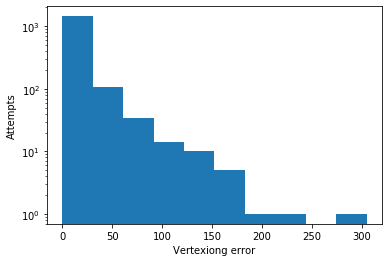

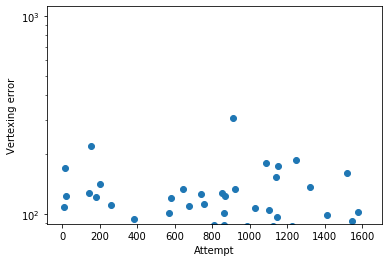

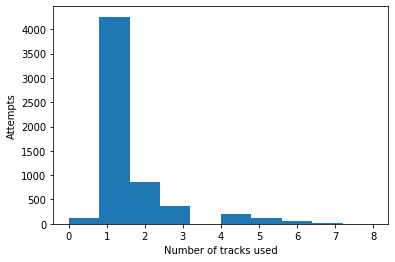

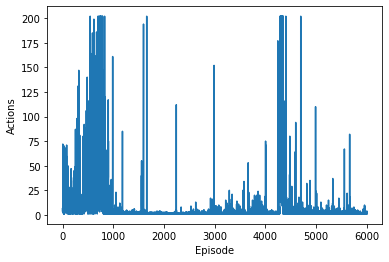

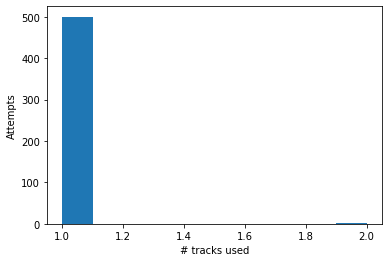

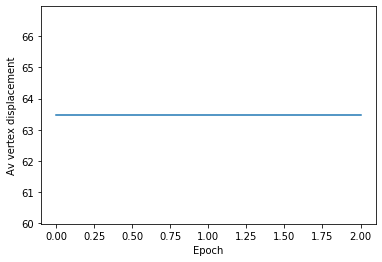

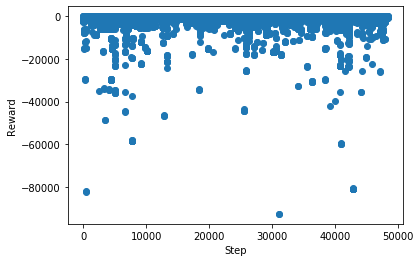

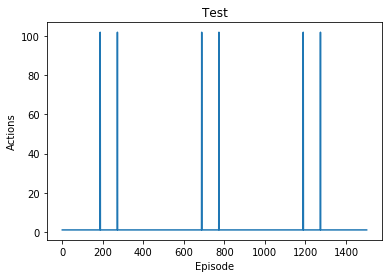

6003
7747


In [28]:
plt.hist(final_poca_dist)
plt.xlabel("Vertexiong error")
plt.ylabel("Attempts")
#plt.title("Vertexing error")
plt.yscale('log')
plt.savefig(f"{directory}RL_poca_displacement.png")
plt.show()

plt.scatter(range(len(final_poca_dist)), final_poca_dist)
plt.xlabel("Attempt")
plt.ylabel("Vertexing error")
#plt.title("Vertexing error")
plt.yscale('log')
plt.savefig(f"{directory}RL_poca_displacement.png")
plt.show()


plt.hist(ntracks_used)
#plt.title("Number of tracks used")
plt.xlabel("Number of tracks used")
plt.ylabel("Attempts")
plt.savefig(f"{directory}RL_ntracks.png")
plt.show()

plt.plot(episode_lengths)
#plt.title("Actions in an episode")
plt.xlabel("Episode")
plt.ylabel("Actions")
plt.savefig(f"{directory}RL_epilength.png")
plt.show()

plt.hist(test_ntracks_used)
plt.xlabel(r"# tracks used")
plt.ylabel("Attempts")
plt.savefig(f"{directory}RL_test_ntracks.png")
plt.show()

plt.plot(av_test_poca_dist)
plt.xlabel("Epoch")
plt.ylabel("Av vertex displacement")
plt.savefig(f"{directory}RL_displacement.png")
plt.show()

plt.scatter(range(len(rewards)), rewards)
plt.xlabel("Step")
plt.ylabel("Reward")
plt.savefig(f"{directory}RL_rewards.png")
plt.show()

plt.plot(test_episode_lengths)
plt.title("Test")
plt.xlabel("Episode")
plt.ylabel("Actions")
plt.savefig(f"{directory}RL_test_epilength.png")
plt.show()
print(counter)

print(len(memory))
